In [1]:
#import of packages
import networkx as nx
import matplotlib.pyplot as plt
import random  
import numpy as np
import sys
from  fractions import Fraction
import timeit
from time import sleep
from collections import defaultdict
import heapq as heap
from tqdm import tqdm
from community import community_louvain
import collections 
import matplotlib.cm as cm
import statistics

from IPython.display import HTML, display
from itertools import chain, combinations
from itertools import islice
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from joblib import Parallel, delayed
import csv
from pprint import pprint
import math
from operator import itemgetter
import itertools
import scipy
from scipy import stats
from IPython.core.magic import register_line_magic
from IPython.display import HTML, display
import json
import powerlaw
from decimal import Decimal

In [3]:
#code to set probability of the edges
def set_weight_degree(G,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= 1/G.in_degree(v)
    return G

def set_weight_trivalency(G,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= random.choice([0.1,0.01,0.001])
    return G

def set_weight_value(G,val,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= round(val,3)
    return G

def set_weight_average(G,p_n):
    avg=sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())
    for u,v in G.edges():
        G[u][v][p_n]= 1/avg
    return G

def set_weight_comm(G,inter,intra,p_n):
    for u,v in G.edges():
        if G.nodes[u]['community']== G.nodes[v]['community']:
            G[u][v][p_n]= inter
        else:
            G[u][v][p_n]= intra
    return G


In [4]:
#code to visualize degree distribution
def plot_degree_dist(G):
    degrees = [G.out_degree(n) for n in G.nodes()]
    plt.hist(degrees,bins=20)
    plt.show()
def plot_log_degree_dist(G):
    degrees = [np.log(G.out_degree(n)) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

In [31]:
def hichoba(n,r,h,p_PA,p_out,p_R,p_T):
    num_com=len(r)
    G= nx.Graph()
    nx.set_node_attributes(G, [], "community")
    G.add_nodes_from(range(num_com))
    nodes=len(G.nodes())
    
    choices_c={c:[] for c in range(num_com)}
    choices_weights_c={c:{} for c in range(num_com)}
    
    c=0
    for v in G.nodes():
        G.nodes[v]['community']= c
        choices_c[c].append(v)
        choices_weights_c[c][v]=1
        c+=1
        
    
    print(G.nodes())
    print(G.edges())
    print([(x,G.nodes[x]['community']) for x in G.nodes()])
    
    iter=len(G.nodes())+len(G.edges())-len(G.nodes())
    L_values,x_val=[],[]
    pbar = tqdm(total=n, position=0, leave=True)
    pbar.update(len(G.nodes()))
    while nodes<=n:
        h=min(iter*0.05,0.8)
        if random.uniform(0,1)<=p_PA:
            
            G.add_node(nodes-1)
            source=nodes-1
            nodes+=1
            c=random.choices(range(num_com), weights=r, k=1)[0]
            G.nodes[source]['community']= c

            choices_c[c].append(source)
            choices_weights_c[c][source]=1 

            choices=[x for x in choices_c[c] if x!=source]

            if random.uniform(0, 1)<=p_R:weights=[1 for v in choices]
            else:weights=[choices_weights_c[G.nodes[v]['community']][v] for v in choices]
            
            
            if len(choices)==0:continue
            target=random.choices(choices, weights=weights, k=1)[0]

            G.add_edge(source, target)

            choices_weights_c[c][source]+=1
            choices_weights_c[G.nodes[target]['community']][target]+=1
            pbar.update(1)

        else:
            if random.uniform(0,1)<=p_T:
                if random.uniform(0,1)<=p_R:
                    if len([x for x in G.nodes() if G.degree(x)>=2])==0:continue
                    v=random.choice([x for x in G.nodes() if G.degree(x)>=2])
                else:
                    if len([x for x in G.nodes() if G.degree(x)>=2])==0:continue
                    v=random.choices([x for x in G.nodes() if G.degree(x)>=2], weights=[G.degree(x)+1 for x in G.nodes() if G.degree(x)>=2],k=1)[0]
                
                target1=random.choice(list(G.neighbors(v)))
                options=[y for y in G.neighbors(v) if not G.has_edge(target1,y)]
                if len(options)==0: continue
                intra_inter= random.uniform(0, 1)
                if intra_inter<=h: choices=[x for x in options if G.nodes[v]['community']==G.nodes[x]['community']]
                else:choices=[x for x in options if G.nodes[v]['community']!=G.nodes[x]['community']]
                    
                if random.uniform(0, 1)<=p_R:weights=[1 for w in options]
                else: weights=[choices_weights_c[G.nodes[w]['community']][w] for w in options] 
                
                if len(options)==0: print("no ", intra_inter);continue
                target2=random.choices(options, weights=weights, k=1)[0]
                
                G.add_edge(target1, target2)
                choices_weights_c[G.nodes[target1]['community']][target1]+=1
                choices_weights_c[G.nodes[target2]['community']][target2]+=1
                
                
            else:
                if random.uniform(0,1)<=p_R:
                    v=random.choice([x for x in G.nodes() ])
                else:
                    v=random.choices([x for x in G.nodes() ], weights=[G.degree(x)+1 for x in G.nodes()],k=1)[0]
                    
                neigh=list( G.neighbors(v))
                options=[x for x in G.nodes() if x not in neigh]
                intra_inter= random.uniform(0, 1)
                if intra_inter<=h: choices=[x for x in options if G.nodes[v]['community']==G.nodes[x]['community']]
                else:choices=[x for x in options if G.nodes[v]['community']!=G.nodes[x]['community']]

                if random.uniform(0, 1)<=p_R:weights=[1 for v in choices]
                else:weights=[choices_weights_c[G.nodes[v]['community']][v] for v in choices] 

                if len(choices)==0:continue
                target=random.choices(choices, weights=weights, k=1)[0]
                if (intra_inter>h and random.uniform(0,1)<=r[G.nodes[target]['community']]/r[G.nodes[v]['community']]) or intra_inter<h :
                    G.add_edge(v, target)

                    choices_weights_c[G.nodes[v]['community']][v]+=1
                    choices_weights_c[G.nodes[target]['community']][target]+=1
        iter+=1
        if False:
            if nodes in [10,100,1000,10000]: L_values.append(nx.average_shortest_path_length(G));x_val.append(nodes) 
    if False:           
        fig,ax = plt.subplots(1)
        ax.plot(x_val,L_values)
        ax.set_xscale('log')
    pbar.close()            
    return G

In [ ]:
#example code to generate a synthetic network, this is SG5 in the report
n=10000 # number of iterations 
r=[0.54,0.3,0.15,0.005,0.005]
h=0.2
p_PA=(n/(10*n))*2
p_T=0.9
p_out=1
p_R=0.1
Homo_BA=hichoba(n,r,h,p_PA,p_out,p_R,p_T)
Homo_BA=Homo_BA.to_directed()

print(nx.attribute_assortativity_coefficient(Homo_BA, "community"))
print("nodes:"+str(len(Homo_BA.nodes()))+" edges:"+str(len(Homo_BA.edges())))
print("Average degree :"+str(sum([Homo_BA.out_degree(x) for x in Homo_BA.nodes()])/len(Homo_BA.nodes())))
print(sorted([(Homo_BA.out_degree(x),x) for x in Homo_BA.nodes()],reverse=True)[0:10]) 

for e in Homo_BA.edges():
    if Homo_BA.nodes[e[0]]['community'] == Homo_BA.nodes[e[1]]['community']:
        intra_edges+=1
    else:
        inter_edges+=1
print(inter_edges,intra_edges)

print("clustering coefficient: "+str(nx.average_clustering(Homo_BA,Homo_BA.nodes())))
degree_freq = nx.degree_histogram(Homo_BA.to_undirected())
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

nodes:18772 edges:396160
Astro
number of comm  331
nodes:18772 edges:396160
Average degree :21.1037715746857
[504, 427, 420, 418, 387, 384, 369, 362, 351, 350]
clustering coefficient: 0.6305932411707943


Text(0, 0.5, 'Frequency')

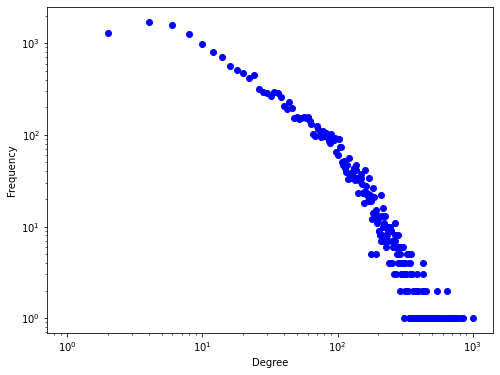

In [5]:
def load_AS(): # load coathorship dataset as graph2
    g=nx.DiGraph()
    with open("CA-AstroPh.txt") as file:
        for line in file:
            s_line = line.strip()
            list_line=s_line.split()
            g.add_edge(list_line[0],list_line[1])
    #g=nx.convert_node_labels_to_integers(g)
    
    partition=community_louvain.best_partition(g.to_undirected())
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
        
    
    g=nx.convert_node_labels_to_integers(g)
    return g

Astro=load_AS() 
if True:
    #Gcc = sorted(nx.connected_components(NetPhy), key=len, reverse=True)
    #NetPhy = NetPhy.subgraph(Gcc[0])
    print("nodes:"+str(len(Astro.nodes()))+" edges:"+str(len(Astro.edges())))
    Astro=nx.convert_node_labels_to_integers(Astro)
    Astro=Astro.to_directed(as_view=False)
    print("Astro")
    d=collections.Counter([Astro.nodes[i]['community'] for i in Astro.nodes()])
    #print(collections.OrderedDict(sorted(d.items())))
    print("number of comm " ,len(d))
    print("nodes:"+str(len(Astro.nodes()))+" edges:"+str(len(Astro.edges())))
    print("Average degree :"+str(sum([Astro.out_degree(x) for x in Astro.nodes()])/len(Astro.nodes())))
    print(sorted([Astro.out_degree(x) for x in Astro.nodes()],reverse=True)[0:10]) 
    print("clustering coefficient: "+str(nx.average_clustering(Astro,Astro.nodes())))
    
degree_freq = nx.degree_histogram(Astro)
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree")
plt.ylabel("Frequency")


 67%|████████████████████████████████████████████████▎                       | 671/1000 [21:15:02<10:25:10, 114.01s/it]


nodes:37149 edges:174161
NetPhy
number of comm  3947
nodes:37149 edges:348322
Average degree :9.376349296077956
[178, 167, 153, 150, 141, 141, 138, 137, 136, 135]
clustering coefficient: 0.7533992524002633


(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

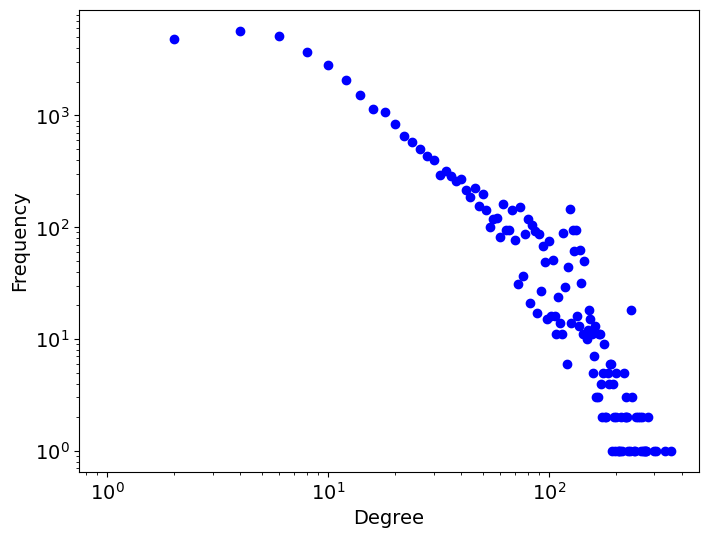

In [39]:
def load_NetPhy(): # load coathorship dataset as graph2
    g=nx.Graph()
    with open("phy.txt") as file:
        for line in file:
            s_line = line.strip()
            list_line=s_line.split()
            g.add_edge(list_line[0],list_line[1])
    #g=nx.convert_node_labels_to_integers(g)
    
    partition=community_louvain.best_partition(g.to_undirected())
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
        
    
    g=nx.convert_node_labels_to_integers(g)
    return g

NetPhy=load_NetPhy() 
if True:
    #Gcc = sorted(nx.connected_components(NetPhy), key=len, reverse=True)
    #NetPhy = NetPhy.subgraph(Gcc[0])
    print("nodes:"+str(len(NetPhy.nodes()))+" edges:"+str(len(NetPhy.edges())))
    NetPhy=nx.convert_node_labels_to_integers(NetPhy)
    NetPhy=NetPhy.to_directed(as_view=False)
    print("NetPhy")
    d=collections.Counter([NetPhy.nodes[i]['community'] for i in NetPhy.nodes()])
    #print(collections.OrderedDict(sorted(d.items())))
    print("number of comm " ,len(d))
    print("nodes:"+str(len(NetPhy.nodes()))+" edges:"+str(len(NetPhy.edges())))
    print("Average degree :"+str(sum([NetPhy.out_degree(x) for x in NetPhy.nodes()])/len(NetPhy.nodes())))
    print(sorted([NetPhy.out_degree(x) for x in NetPhy.nodes()],reverse=True)[0:10]) 
    print("clustering coefficient: "+str(nx.average_clustering(NetPhy,NetPhy.nodes())))
    
degree_freq = nx.degree_histogram(NetPhy)
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


nodes:36692 edges:367662
Enron
number of comm  174
nodes:33696 edges:361622
Average degree :10.731896961063628
[1383, 1367, 1261, 1245, 1244, 1143, 1099, 1068, 1026, 924]
clustering coefficient: 0.5091899019721576


Text(0, 0.5, 'Frequency')

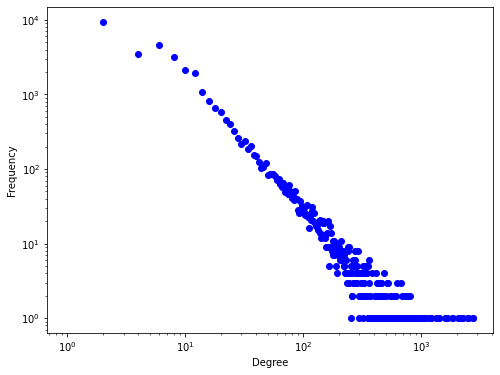

In [46]:
def load_Enron(): # load coathorship dataset as graph2
    g=nx.DiGraph()
    with open("Email-Enron.txt") as file:
        for line in file:
            s_line = line.strip()
            list_line=s_line.split()
            #print(list_line)
            g.add_edge(list_line[0],list_line[1])
    g=nx.convert_node_labels_to_integers(g)
    print("nodes:"+str(len(g.nodes()))+" edges:"+str(len(g.edges())))
    partition=community_louvain.best_partition(g.to_undirected())
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
    return g.to_directed()

Enron=load_Enron() 
if True:
    Gcc = sorted(nx.connected_components(Enron.to_undirected()), key=len, reverse=True)
    Enron = Enron.subgraph(Gcc[0])
    #Enron=nx.convert_node_labels_to_integers(Enron)
    #Enron=Enron.to_directed(as_view=False)
    print("Enron")
    d=collections.Counter([Enron.nodes[i]['community'] for i in Enron.nodes()])
    #print(collections.OrderedDict(sorted(d.items())))
    print("number of comm " ,len(d))
    print("nodes:"+str(len(Enron.nodes()))+" edges:"+str(len(Enron.edges())))
    print("Average degree :"+str(sum([Enron.out_degree(x) for x in Enron.nodes()])/len(Enron.nodes())))
    print(sorted([Enron.out_degree(x) for x in Enron.nodes()],reverse=True)[0:10]) 
    print("clustering coefficient: "+str(nx.average_clustering(Enron,Enron.nodes())))
    
degree_freq = nx.degree_histogram(Enron)
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree")
plt.ylabel("Frequency")


NetTh
number of comm  1818
nodes:15235 edges:62776
Average degree :4.120511978995734
[64, 61, 54, 53, 53, 53, 52, 52, 51, 51]
clustering coefficient: 0.4983828585051554


Text(0, 0.5, 'Frequency')

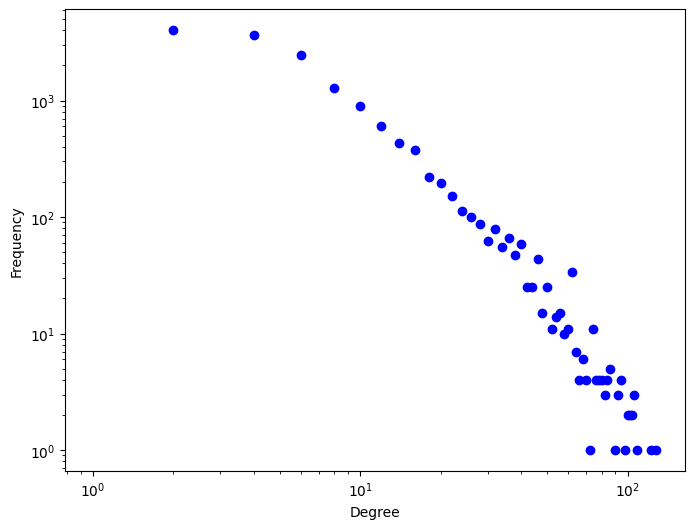

In [47]:
def load_NetTh(): # load coathorship dataset as graph2
    g=nx.Graph()
    with open("hep.txt") as file:
    #with open("facebook-wosn-wall.edges") as file:
        for line in file:
            s_line = line.strip()
            list_line=s_line.split()
            #list_line=s_line.split(",")
            #print(list_line,(list_line[0],list_line[1]))
            g.add_edge(list_line[0],list_line[1])
    #g=nx.read_edgelist("hep.txt", nodetype=int,create_using=nx.Graph())
    g=nx.convert_node_labels_to_integers(g)
    partition=community_louvain.best_partition(g)
    
    communities= [x for x in partition.values()]
    num_com=len(np.unique(communities))

    pop_communities=[0]*num_com    
    for c in range(num_com):
        pop_communities[c]=[v for k,v in partition.items()].count(c)
    nodes_g=list(g.nodes())
    for node in nodes_g:
        if  pop_communities[partition[node]]<=0: g.remove_node(node)
        else:
            g.nodes[node]['community']=partition[node]
    g=nx.convert_node_labels_to_integers(g)    
    return g.to_directed()


NetTh=load_NetTh() 
if True:
    #Gcc = sorted(nx.connected_components(Enron.to_undirected()), key=len, reverse=True)
    #Enron = Enron.subgraph(Gcc[0])
    #Enron=nx.convert_node_labels_to_integers(Enron)
    #Enron=Enron.to_directed(as_view=False)
    print("NetTh")
    d=collections.Counter([NetTh.nodes[i]['community'] for i in NetTh.nodes()])
    #print(collections.OrderedDict(sorted(d.items())))
    print("number of comm " ,len(d))
    print("nodes:"+str(len(NetTh.nodes()))+" edges:"+str(len(NetTh.edges())))
    print("Average degree :"+str(sum([NetTh.out_degree(x) for x in NetTh.nodes()])/len(NetTh.nodes())))
    print(sorted([NetTh.out_degree(x) for x in NetTh.nodes()],reverse=True)[0:10]) 
    print("clustering coefficient: "+str(nx.average_clustering(NetTh,NetTh.nodes())))
    
degree_freq = nx.degree_histogram(NetTh)
degrees = range(len(degree_freq))
plt.figure(figsize=(4, 3)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree")
plt.ylabel("Frequency")


Twitter
number of comm  70
nodes:81306 edges:1768149
Average degree :21.74684525127297
[1205, 1158, 1111, 1069, 930, 724, 719, 713, 705, 687]


Text(0, 0.5, 'Frequency')

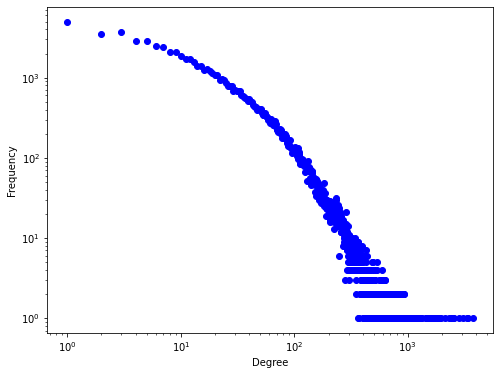

In [5]:
def load_Twitter(): # load coathorship dataset as graph2
    g=nx.read_edgelist("twitter_combined.txt", nodetype=int,create_using=nx.DiGraph())
    g=nx.convert_node_labels_to_integers(g)
    partition=community_louvain.best_partition(g.to_undirected())
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
    return g


Twitter=load_Twitter() 
Twitter=nx.convert_node_labels_to_integers(Twitter)
Twitter=Twitter.to_directed(as_view=False)
print("Twitter")
d=collections.Counter([Twitter.nodes[i]['community'] for i in Twitter.nodes()])
#print(collections.OrderedDict(sorted(d.items())))
print("number of comm " ,len(d))
print("nodes:"+str(len(Twitter.nodes()))+" edges:"+str(len(Twitter.edges())))
print("Average degree :"+str(sum([Twitter.out_degree(x) for x in Twitter.nodes()])/len(Twitter.nodes())))
print(sorted([Twitter.out_degree(x) for x in Twitter.nodes()],reverse=True)[0:10]) 
#print("clustering coefficient: "+str(nx.average_clustering(Twitter,Twitter.nodes())))


degree_freq = nx.degree_histogram(Twitter)
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree")
plt.ylabel("Frequency")

done
Facebook_small
number of comm  16
nodes:4039 edges:176468
Average degree :43.69101262688784
[1045, 792, 755, 547, 347, 294, 291, 254, 245, 235]
clustering coefficient: 0.6055467186200876
8


Text(0, 0.5, 'Frequency')

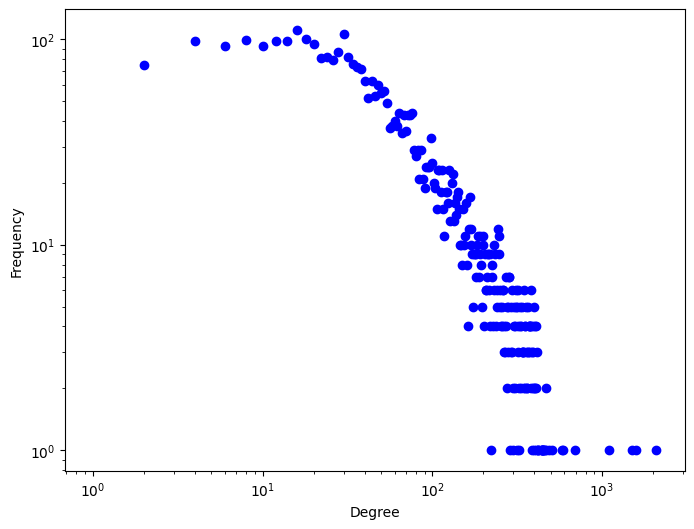

In [37]:
def load_Facebook_small():
    g=nx.Graph()
    with open("facebook_combined.txt") as file:
    #with open("facebook-wosn-wall.edges") as file:
        for line in file:
            s_line = line.strip()
            list_line=s_line.split()
            #list_line=s_line.split(",")
            #print(list_line,(list_line[0],list_line[1]))
            g.add_edge(list_line[0],list_line[1])
    print("done")    
    
    partition=community_louvain.best_partition(g)
    
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
        
    Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
    g = g.subgraph(Gcc[0])
    g=nx.convert_node_labels_to_integers(g)
    
    g=g.to_directed(as_view=False)
    return g

Facebook_small=load_Facebook_small() 

print("Facebook_small")
d=collections.Counter([Facebook_small.nodes[i]['community'] for i in Facebook_small.nodes()])
print("number of comm " ,len(d))

print("nodes:"+str(len(Facebook_small.nodes()))+" edges:"+str(len(Facebook_small.edges())))
print("Average degree :"+str(sum([Facebook_small.out_degree(x) for x in Facebook_small.nodes()])/len(Facebook_small.nodes())))
print(sorted([Facebook_small.out_degree(x) for x in Facebook_small.nodes()],reverse=True)[0:10])     
#print("clustering coefficient: "+str(nx.average_clustering(Facebook,Facebook.nodes())))
print("clustering coefficient: "+str(nx.average_clustering(Facebook_small,Facebook_small.nodes())))
print(nx.diameter(Facebook_small.to_undirected()))

degree_freq = nx.degree_histogram(Facebook_small)
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6)) 
plt.loglog(degrees, degree_freq,'bo') 
plt.xlabel("Degree")
plt.ylabel("Frequency")

In [13]:
def dijkstra_MIA(startingNode, G_path, G_deg,in_edges,min_prob,S_N,p_n): # dijkstra's algorithm to compute the MIIA
    
    MIA = nx.DiGraph()
    MIA.add_node(startingNode)

    prob,probabilities={startingNode: 1},{startingNode:1}
    steps,steps_final={startingNode:0},{startingNode:0}
    parentsMap={}
    
    pq = []
    nodeCosts = defaultdict(lambda: float('inf'))
    nodeCosts[startingNode] = 0
    heap.heappush(pq, (0, startingNode))
 
    while pq:
        # go greedily by always extending the shorter cost nodes first
        _, node = heap.heappop(pq)
        if node in S_N: continue
        if not in_edges:
            neighbors =list(G_path.successors(node))
        else:
            neighbors = list(G_path.predecessors(node))
        for adjNode in neighbors:  
            if not in_edges:    
                weight= -np.log(G_deg[node][adjNode][p_n])
                prob_val= round(G_deg[node][adjNode][p_n]*prob[node],3)
            else:
                weight= -np.log(G_deg[adjNode][node][p_n])
                prob_val= round(G_deg[adjNode][node][p_n]*prob[node],3)
            newCost = nodeCosts[node] + weight
            if nodeCosts[adjNode] > newCost and prob_val>=min_prob :
                parentsMap[adjNode]=node
                nodeCosts[adjNode] = newCost
                prob[adjNode]= prob_val
                steps[adjNode]=steps[node]+1
                heap.heappush(pq, (newCost, adjNode))
                
    for w in  parentsMap.keys() : 
        if  in_edges:
            MIA.add_edge(w,parentsMap[w])
        else:
            MIA.add_edge(parentsMap[w],w)
        probabilities[w]= prob[w]
        steps_final[w]= steps[w]
        
    return  MIA,steps_final,probabilities # we return the MIA and the parentMap in case we need to reconstruct the MIA

In [14]:
def dijkstra_MIOG(startingNode,G, min_prob,S_N): # dijkstra's algorithm to compute the MIOG
    
    MIOG = nx.DiGraph()
    MIOG.add_node(startingNode)
    
    prob,probabilities={startingNode: 1},{startingNode:1}
    steps,steps_final={startingNode:0},{startingNode:0}
    parentsMap={}
    
    pq = []
    nodeCosts = defaultdict(lambda: float('inf'))
    nodeCosts[startingNode] = 0
    heap.heappush(pq, (0, startingNode))
 
    while pq:
        # go greedily by always extending the shorter cost nodes first
        _, node = heap.heappop(pq)
        if node in S_N: continue
       
        neighbors =list(G.successors(node))
        for adjNode in neighbors:  
            
            weight= -np.log(G[node][adjNode]["negative"])
            prob_val= round(G[node][adjNode]["negative"]*prob[node],3)
    
            newCost = nodeCosts[node] + weight
            if nodeCosts[adjNode] > newCost and prob_val>=min_prob :
                parentsMap[adjNode]=[node]
                nodeCosts[adjNode] = newCost
                prob[adjNode]= prob_val
                steps[adjNode]=steps[node]+1
                heap.heappush(pq, (newCost, adjNode))
                continue 
            if nodeCosts[adjNode] == newCost and prob_val>=min_prob and adjNode!=startingNode and  node not in parentsMap[adjNode]  :
                parentsMap[adjNode]=parentsMap[adjNode]+[node]
                
    for w in  parentsMap.keys() : 
        for v in parentsMap[w]:
            MIOG.add_edge(v,w)
        probabilities[w]= prob[w]
        steps_final[w]= steps[w]  
    return  MIOG 

In [15]:
def get_p_value(v,pos,t,S_N,S_P):# initializes the values of P_p_t, P_n_t, ap_n_t and ap_p_t in compute_ap_N
    if v in S_P:
        if pos:
            if t==0: return 1,1 
            else: return 0,1
        else: return 0,0
            
    elif v in S_N:
        if pos: return 0,0
        else: 
            if t==0: return 1,1 
            else: 0,1
    else: return 0,0 

def compute_ap_N(u,S_N,S_P,MIA_n,MIA_p,G): #probability of transmission is inversly proportional to the in-degree  
    
    POS_t=[v for v in S_P if v in MIA_p.nodes() ]
    NEG_t=[v for v in S_N if v in MIA_n.nodes()]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    for node in list(MIA_n.nodes())+list(MIA_p.nodes()):
         
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    
    while NEG_t:
        
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        temp_N={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        
        for v in POS_t: # positive influence has priority
            
            if not list(MIA_p.successors(v)):
                continue
            for w in list(MIA_p.successors(v)):
                POS_next.add(w)
                temp_P[w]*=(1-P_p_t[v]*G[v][w]['positive'])
            
        for v in POS_next:
            
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
             
        for v in NEG_t :
            if not list(MIA_n.successors(v)):
                continue 
            for w in list(MIA_n.successors(v)):
                NEG_next.add(w)
                temp_N[w]*=(1-P_n_t[v]*G[v][w]['negative'])
            
        for v in NEG_next:
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(POS_next): 
            ap_p_t = ap_p_next.copy()  
            
        if list(NEG_next):
            
            ap_n_t = ap_n_next.copy() 
             
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    
    return ap_n_t[u]

def compute_ap_N_WRR(u,S_N,S_P,MIA_n,MIA_p,G,originals): #probability of transmission is inversly proportional to the in-degree  
    #print("v-------> "+str((u,S_N)))
    POS_t=[v for v in S_P if v in MIA_p.nodes() ]
    NEG_t=[v for v in S_N if v in MIA_n.nodes()]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    for node in list(MIA_n.nodes())+list(MIA_p.nodes()):
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    while NEG_t:
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        temp_N={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        
        for v in POS_t: # positive influence has priority
            
            if not list(MIA_p.successors(v)):
                continue
            for w in list(MIA_p.successors(v)):
                if w in S_N: continue
                POS_next.add(w)
                temp_P[w]*=(1-P_p_t[v]*G[originals[v]][originals[w]]['positive'])
            
        for v in POS_next:
            
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
            
        for v in NEG_t :
            if not list(MIA_n.successors(v)):
                continue 
            for w in list(MIA_n.successors(v)):
                if w in S_P: continue
                NEG_next.add(w)
                temp_N[w]*=(1-(P_n_t[v]*G[originals[v]][originals[w]]['negative']))
                
        for v in NEG_next:
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(POS_next): 
            ap_p_t = ap_p_next.copy()  
            
        if list(NEG_next):
            
            ap_n_t = ap_n_next.copy() 
        #print(ap_n_t)    
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    
    return ap_n_t[u]
WRR=nx.DiGraph()
WRR.add_edges_from([(5,8),(6,8),(2,6),("3copy1",6),("1copy1","3copy1"),(3,5),(1,3)])
graph=nx.DiGraph()
graph.add_edges_from([(5,8),(6,8),(2,6),(3,6),(1,3),(3,5)])
graph=set_weight_value(graph,0.5,"positive")
graph=set_weight_value(graph,0.5,"negative")
originals={1:1,2:2,3:3,5:5,6:6,8:8,"3copy1":3,"1copy1":1}
print(compute_ap_N_WRR(8,[1,"1copy1","2copy1",2],["3copy1",3],WRR,WRR,graph,originals))

0.0703125


In [16]:
def compute_ap_N_MIOG(S_N,S_P,MIOG_N,MIOG_P,G): #probability of transmission is inversly proportional to the in-degree  
    
    POS_t=[v for v in S_P if v in MIOG_P.nodes() ]
    NEG_t=[v for v in S_N if v in MIOG_N.nodes()]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    for node in list(MIOG_N.nodes())+list(MIOG_P.nodes()):
         
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    
    while NEG_t:
        
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in list(MIOG_N.nodes())+list(MIOG_P.nodes())}
        temp_N={k:1 for k in list(MIOG_N.nodes())+list(MIOG_P.nodes())}
        
        for v in POS_t: # positive influence has priority
            
            if not list(MIOG_P.successors(v)):
                continue
            for w in list(MIOG_P.successors(v)):
                POS_next.add(w)
                temp_P[w]*=(1-P_p_t[v]*G[v][w]['positive'])
            
        for v in POS_next:
            
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
             
        for v in NEG_t :
            if not list(MIOG_N.successors(v)):
                continue 
            for w in list(MIOG_N.successors(v)):
                NEG_next.add(w)
                temp_N[w]*=(1-P_n_t[v]*G[v][w]['negative'])
            
        for v in NEG_next: 
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(POS_next): 
            ap_p_t = ap_p_next.copy()  
            
        if list(NEG_next):
            
            ap_n_t = ap_n_next.copy() 
          
            
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    
    return ap_n_t




In [17]:
def get_communities(part,G): # returns the number of communities in G given the partition part
    communities = []
    for i in G.nodes():
        if part[i] not in communities:
            communities.append(part[i])
    return len(communities)

def path_blocked_MIA(from_node,to_node, MIIA, S): # if a negative information needs to go through a node in S_P the path is blocked
    start=timeit.default_timer()
    current_node=from_node
    if current_node in S:
        return True
    while current_node != to_node and list(MIIA.successors(current_node)):
        if list(MIIA.successors(current_node))[0] in S:
            return True
        else:
            current_node=list(MIIA.successors(current_node))[0]
    return False

def path_blocked_MOA(from_node,to_node, MIOA, S): # if a negative information needs to go through a node in S_P the path is blocked
    current_node=to_node
    if current_node in S:
        return True
    while current_node != from_node:
        if list(MIOA.predecessors(current_node))[0] in S:
            return True
        else:
            current_node=list(MIOA.predecessors(current_node))[0] 
    return False

def cost(S_P,funct,G,avg_deg=1):
    if funct=="uniform":
        return len(S_P)
    if funct=="degree_penalty":
        if len(S_P)==0: return 0
        return np.sum([G.out_degree(x) for x in S_P])/(avg_deg)

In [18]:
def CMIA_O(G,S_N,k,min_prob,cost_function="uniform"): # we reduce the propagation to the maximum probability paths and choose node with biggest reduction in overall probability of infection
    avg_deg=sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())
    start = timeit.default_timer()
    S_P=[]
    Neg_range=set() # nodes that could be reached by S_N with probability higer than min_prob
    DecInf={} # dictionary storing the contribution a node has if added to S_P
    MIA_prev_nodes={}# to keep track of the MIIAs without having to recompute them
    steps_v={}
    proba_v={}
    
    for u in tqdm(S_N, position=0,leave=True):
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob,[],"negative")
        for v in list(set(MIOA.nodes()) - set(S_N)):
            Neg_range.add(v) # contains the nodes that could get infected
   
    
    for u in tqdm(Neg_range, position=0,leave=True): # for each node that gets ifected  we compute how much the probability of infection value lowers if we add a node to the seed
         
        MIIA,steps,probs=dijkstra_MIA(u, G,G, True, min_prob,[],"negative") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_prev_nodes[u]= [e for e in MIIA.edges()].copy() #skeleton of MIIA 
        steps_v[u]= {key:val for key, val in steps.items()}
        
        ap=compute_ap_N(u,S_N,[], MIIA, MIIA ,G) # probability of infection of  u if we dont intervene
        if ap==0: continue
        longest= max([x for x in steps.items() if x[0] in S_N and not path_blocked_MIA(x[0],u, MIIA, list(set(S_N)-set([x[0]])))],key=lambda item:item[1])[0]
        for v in [x for x in list(MIIA.nodes()) if steps[x]<= steps[longest] and  not path_blocked_MIA(x,u, MIIA, S_N) ]:
            ap_v= compute_ap_N(u,S_N, S_P+[v], MIIA, MIIA ,G)# probability of infection of u if v is added to S_P
            
            if v in DecInf:
                DecInf[v]+=(ap-ap_v) #compute total impact of the node as truth campaigner 
            else:
                DecInf[v]=(ap-ap_v) 
    while cost(S_P,cost_function,G,avg_deg)< k:
    #for i in tqdm(range(k), position=0, leave=True): 
        
        candidates={key:v for key,v in DecInf.items() if key not in S_N+list(S_P) and cost(S_P+[key],cost_function,G,avg_deg)<= k}
        if len(candidates)==0:break
        u = max(candidates,key=candidates.get) # chose node with higest impact
    
        #we now proceed to update the contribution of each node
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob,[],"negative")
        #print(u,list(MIOA.nodes()))
        for v in [x for x in MIOA.nodes() if x in Neg_range and  not path_blocked_MOA(u,x, MIOA, S_N+S_P)  ]: # nodes that u could potentially save 
            
            MIIA.clear() # we recontruct the MIIA, which we already computed and stored
            MIIA.add_edges_from(MIA_prev_nodes[v])
            
            longest= max([x for x in steps_v[v].items() if x[0] in S_N and not path_blocked_MIA(x[0],v, MIIA, S_P)],key=lambda item:item[1], default=(None,None))[0]
            if longest==None:continue

            ap=compute_ap_N(v,S_N,S_P,MIIA, MIIA ,G) #probability of infection of v with current S_P
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA, MIIA,G) #probability of infection of v with current S_P which now includes u
            
            for w in [x for x in list(MIIA.nodes()) if steps_v[v][x]<= steps_v[v][longest]  and  not path_blocked_MIA(x,v, MIIA, S_N+S_P)]: #nodes whose contribution now decreses since u helps
                ap_w=compute_ap_N(v,S_N,S_P+ [w], MIIA, MIIA ,G) # probability of infection of v if w is added to S_P
                
                if w in DecInf: 
                    DecInf[w]-=(ap-ap_w) #we update the contribution of w to be the one after we add u
                if v!=u:
                    ap_u_w=compute_ap_N(v,S_N,S_P+[u]+[w], MIIA, MIIA ,G)# probability of infection of v if w is added to S_P which now includes u

                    if w in DecInf:
                        DecInf[w]+=(ap_u-ap_u_w)
        S_P.append(u)                     
    stop = timeit.default_timer()
    print('Time: ', stop - start) 
    return S_P 

In [19]:
#%bg #e8b5ce
# this version tries to help the community where the least percentage of nodes has been saved
def CMIA_O_fair_new(G,S_N,k,min_prob,partition,cost_function="uniform"): # we now consider the communities, and take as input the partition
    avg_deg=sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())
    start = timeit.default_timer()
    S_P=[]
    Neg_range=set()# nodes that could be reached by S_N with probability higer than min_prob
    communities=get_communities(partition,G)
    MIA_edges_n,MIA_p_edges={},{}# to keep track of the MIIAs without having to recompute them
    DecInf_per_comm={}# dictionary storing the contribution per community a node has if added to S_P 
    E_inf_num=[0]*communities # value of expected infected nodes per community
    saved_per_comm=[0]*communities # expected number of saved nodes per community
    steps_n,steps_p={},{}
    proba_n,proba_p={},{}
    
    inf=[]
    for u in S_N:
        MIOA,s,p=dijkstra_MIA(u, G,G, False, min_prob,[],"negative")
        for v in list(set(MIOA.nodes()) - set(S_N)- set(Neg_range)):
            Neg_range.add(v) # contains the nodes that could get infected
            inf.append((v,u))
    print(len(Neg_range))
    time=0
    time1=0 
    for u in  tqdm(Neg_range, position=0,leave=True):# for each node that gets ifected  we compute how much the probability of infection value lowers if we add a node to the seed
        s1=timeit.default_timer()
        MIIA,steps,probs =dijkstra_MIA(u, G,G, True, min_prob,S_N,"negative") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_edges_n[u]= [e for e in MIIA.edges()].copy() #skeleton of MIIA
        steps_n[u]= {key:val for key, val in steps.items()}
        
        
            
        MIIA_p,steps_pos,probs_p = dijkstra_MIA(u, G,G, True, min_prob,S_N,"positive") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_p_edges[u]= [e for e in MIIA_p.edges()].copy() #skeleton of MIIA
        steps_p[u]= {key:val for key, val in steps_pos.items()}
        time+=timeit.default_timer()-s1
        s2=timeit.default_timer()
        ap=compute_ap_N(u,S_N, S_P, MIIA, MIIA_p, G)# probability of infection of u if we dont intervene
        if ap==0: 
            continue
        
        
        time1+=timeit.default_timer()-s2
        infectees=[x for x in MIIA.nodes() if x in S_N]
        
        longest= [x for _, x in sorted(zip([steps[x] for x in infectees], infectees), reverse=True)][0]
        
        #print(len(infectees))
        E_inf_num[partition[u]]+=ap # we add the propability of infection of u to our expected value within its community
        
        for v in [x for x in list(set(MIIA_p.nodes())-set(S_N)) if steps_pos[x]<= steps[longest]] :
            s2=timeit.default_timer()
            if len(infectees)==1 and path_blocked_MIA(u,infectees, MIIA, [v]): ap_v=0
            else: ap_v= compute_ap_N(u,S_N, S_P + [v], MIIA,MIIA_p ,G) # probability of infection of u if v is added to S_P
            time1+=timeit.default_timer()-s2
            if v in DecInf_per_comm:
                DecInf_per_comm[v][partition[u]]+= (ap-ap_v)
            else:
                DecInf_per_comm[v]=[0]*communities
                DecInf_per_comm[v][partition[u]]= (ap-ap_v) #compute total impact of the node as truth campaigner per community 
           
    E_inf_num=[round(x,1) for x in E_inf_num] 
    
    while cost(S_P,cost_function,G,avg_deg)< k:
        
        percentage_saved=[float(saved_per_comm[c]/E_inf_num[c]) if E_inf_num[c]!=0 else 1  for c in range(communities) ]
        need_saving=[c for c in range(communities) if percentage_saved[c]==min(percentage_saved)]# communities with minimum percentage of saved nodes
        DecInf_needed={v:sum([DecInf_per_comm[v][c] for c in need_saving ]) for v in DecInf_per_comm} # contibution of each node within the communities that need_saving
            
        Saved_per_com_v={} # dictionary storing percentage of nodes we expect to save if we add v to S_P per community
        for key in DecInf_per_comm.keys():
            Saved_per_com_v[key]=[float((saved_per_comm[c]+DecInf_per_comm[key][c])/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]
                
        candidates={n:min(v) for n,v in Saved_per_com_v.items() if n not in S_N+list(S_P) and cost(S_P+[n],cost_function,G,avg_deg)<= k} # we store for each node the min percentage of saved nodes in a community if added to S_P
        candidates=dict(sorted(candidates.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True)) # some might tie, so we order them in descending order of DecInf_needed vaue
        if len(candidates)==0:break    
         
        u = max(candidates,key=candidates.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        #print(u)
        saved_per_comm=[DecInf_per_comm[u][c]+saved_per_comm[c] for c in range(communities)] # we update the expected number of saved nodes
        #we now proceed to update the contribution of each node
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob, S_N+S_P,"positive")
        
        for v in [x for x in MIOA.nodes() if x in Neg_range]: # nodes that u could potentially save  
            
            MIIA.clear() # we recontruct the MIIA, which we already computed and stored
           
            MIIA.add_edges_from(MIA_edges_n[v]) 
           
            
            MIIA_p.clear() # we recontruct the MIIA, which we already computed and stored
            MIIA_p.add_edges_from(MIA_p_edges[v]) 
            
           
            
            longest= max([x for x in steps_n[v].items() if x[0] in S_N and not path_blocked_MIA(x[0],v, MIIA, S_P)],key=lambda item:item[1], default=(None,None))[0]
            if longest==None:continue
            
            ap=compute_ap_N(v,S_N,S_P,MIIA,MIIA_p ,G) #probability of infection of v with current S_P 
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA,MIIA_p,G) #probability of infection of v with current S_P which now includes u 
            for w in [x for x in list(set(MIIA_p.nodes())-set(S_N)) if steps_p[v][x]<= steps_n[v][longest] ]: #nodes whose contribution now decreses since u helps 
                #if  path_blocked_MIA(w,v, MIIA, S_N):continue  # if we have to go through a negative seed to reach v, we cant save him with w and we continue
                ap_w=compute_ap_N(v,S_N, S_P + [w], MIIA,MIIA_p ,G) # probability of infection of v if w is added to S_P
                
                DecInf_per_comm[w][partition[v]]-=(ap-ap_w) #remove all influence of w when u was not in S_P  
                if ap<min_prob: continue
                if v!=u or ap_u==0:    
                    ap_u_w=compute_ap_N(v,S_N,S_P +[w]+[u],MIIA,MIIA_p ,G)
                    DecInf_per_comm[w][partition[v]]+=(ap_u-ap_u_w)
                    
               
        S_P.append(u)
        
    saved_per_comm_final=[float((saved_per_comm[c]+DecInf_per_comm[key][c])/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]     
            
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P 

In [20]:
#%bg #ffe6cc
def BIOG(G,S_N,k,min_prob,cost_function="uniform"): # we now consider the communities, and take as input the partition
    avg_deg=sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())
    start = timeit.default_timer()
    S_P=[]
    MIOGs_N,MIOGs_P={},{}
    MIOGs_ap={}
    contribution={}
    candidates_s={}
    
    candidates=set()
    candidates_s={}
    time,time1,time2=0,0,0
    for s in tqdm(S_N, position=0,leave=True):
        s1=timeit.default_timer()
        MIOG=dijkstra_MIOG(s, G, min_prob,list(set(S_N)- set([s])))
        #print(len(MIOG.nodes()))
        time+=timeit.default_timer()-s1
        MIOGs_N[s]=[e for e in MIOG.edges()].copy()
        MIOGs_P[s]=[e for e in MIOG.edges()].copy()+[(w,u) for u in MIOG.successors(s) for w in G.predecessors(u)]
        MIOG_P=nx.DiGraph()
        MIOG_P.add_edges_from(MIOGs_P[s])
       # print(len(MIOG_P.nodes()))
        
        steps1=[x for x in MIOG.successors(s) if x not in S_N] 
        steps2=[x for u in steps1 for x in G.predecessors(u) if x not in S_N]                    
        candidates.update(steps1+steps2)
        candidates_s[s]=set(steps1+steps2)
        MIOGs_ap[s]=compute_ap_N_MIOG(S_N,[],MIOG,MIOG_P,G)
            
        for candidate in candidates_s[s]:
                if candidate not in contribution.keys() :contribution[candidate]=0
                first,second=0,0
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate]+= MIOGs_ap[s][v] 
                        first+=MIOGs_ap[s][v] 
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  list(nx.descendants(MIOG,v))+[v] if w!= candidate]:
                    contribution[candidate]+=MIOGs_ap[s][w]*G[candidate][v]["positive"]
                    second+= MIOGs_ap[s][w]*G[candidate][v]["positive"]

                
        
    pbar=tqdm(total=k, position=0, leave=True)      
    while cost(S_P,cost_function,G,avg_deg)< k:
        options={n:contribution[n] for n in candidates if cost(S_P+[n],cost_function,G,avg_deg)<= k} # we store for each node the min percentage of saved nodes in a community if added to S_P
        
        if not options: break
        u = max(options,key=options.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        S_P.append(u)   
        pbar.update(1)
        candidates.remove(u)
        
        for s in S_N: # updates
            MIOG=nx.DiGraph()
            MIOG.add_edges_from(MIOGs_N[s])
            MIOG_P=nx.DiGraph()
            MIOG_P.add_edges_from(MIOGs_P[s])
            if u not in MIOG_P.nodes(): continue                                             
            ap_before= MIOGs_ap[s].copy()                                                
            MIOGs_ap[s][u]=0  
            contribution[u]=0
            N_up=[]
            
            common=list(set(MIOG_P.successors(u))& set(set(MIOG.successors(s))))
            for v in common:
                MIOGs_ap[s][v]*=(1-G[u][v]["positive"])  
                
            if u in MIOG.nodes(): common+[u]    
            next_level_common=[v for w in common for v in MIOG.successors(w)] 
            
            while next_level_common:
                for v in next_level_common:
                    p= 1-np.prod([1-MIOGs_ap[s][node]*G[node][v]["negative"] for node in MIOG.predecessors(v)])
                    MIOGs_ap[s][v]=p*(1-np.sum([G[node][v]["positive"] for node in MIOG.predecessors(v) if node in S_P]))
                    N_up+=[x for x in nx.ancestors(MIOG_P,v) if x in candidates_s[s]]
                    
                next_level_common= [v for w in next_level_common for v in MIOG.successors(w)] 
                                                               
            for candidate in set(N_up)-set(S_P):
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate]+= MIOGs_ap[s][v] -ap_before[v]
                
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  nx.descendants(MIOG,v) if w!= candidate]  :
                     contribution[candidate]+=MIOGs_ap[s][w]*G[candidate][v]["positive"] -ap_before[w]*G[candidate][v]["positive"]
                
    pbar.close()    
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P


In [21]:
def compute_threat_levels(G,S_N):
    s1= timeit.default_timer()
    G_source=G.copy()
    G_source.add_edges_from([("new",x) for x in S_N])
    G_source.remove_edges_from([e for e in G.edges() if  e[1] in S_N])
    DAG=nx.DiGraph()
    sign={}
    
    new_nodes= collections.deque()
    new_nodes.append(("new",0))
    visited=set()
    
    
    DAG.add_edges_from(nx.dfs_edges(G_source,source="new",depth_limit=10))
    order= list(nx.dfs_preorder_nodes(DAG, source="new"))
    if False:
        while new_nodes:
            vertex,depth = new_nodes.pop()
            if vertex in visited:continue
            visited.add(vertex)
            order.append(vertex)
            for neighbor in list(G_source.successors(vertex)):
                if neighbor not in visited and neighbor not in DAG.nodes():
                    DAG.add_edge(vertex,neighbor)
                    new_nodes.append((neighbor,depth+1))
                
    #print("DFS done")         
    #print(list(DAG.edges()))
    #print(list(reversed(list(nx.topological_sort(DAG)))))
    #print([(e[0],e[1]) for e in list(DAG.edges()) if e[1]==18])
    #plt.figure()
    #pos=nx.kamada_kawai_layout(DAG)
    #nx.draw(DAG,pos,with_labels=1)
    #plt.show()
    sigma={k:order.index(k) for k in order}
    sign={}
    for u in order:
        #print("u"+str(u)+str(list(DAG.predecessors(u))))
        sign[u]={}
        if u=="new":continue
        
        for p in DAG.predecessors(u):
            #print("p"+str(p))
            sign[u].update(sign[p])
            childreen= list(DAG.successors(p))
            if len(childreen)>1:
                sign[u][p]= u
                
    #print(sign)  
    #print(timeit.default_timer()-s1)
    for e in G.edges():
        #print(e,e[0] not in DAG.nodes(),e[1] not in DAG.nodes())
        if e[0] not in DAG.nodes() or e[1] not in DAG.nodes() or e in DAG.edges() or e[1] in S_N: continue   
        if sigma[e[1]]>=sigma[e[0]]: continue
        set1=set(sign[e[0]])
        set2=set(sign[e[1]])
        if  not set1.intersection(set2): continue
        #print("e"+str(e))
        #print(set1.intersection(set2),sign[e[0]])
        opts={key: sign[e[1]][key] for key in set1.intersection(set2)}
        wu1 = sign[e[0]][max(opts, key=opts.get)]
        #print(wu1,sigma[e[1]],sigma[wu1],sigma[e[0]])
        if sigma[e[1]]<sigma[wu1] and sigma[wu1]<=sigma[e[0]]:
            DAG.add_edge(e[0],e[1])
            #print("yes")
            
    #print(timeit.default_timer()-s1)        
    DAG.remove_nodes_from(["new"])
    print("DAG done")
    #plt.figure()
    #nx.draw_kamada_kawai(DAG,with_labels=1)
    #plt.show()
    reversed_topological_ordering=list(reversed(list(nx.topological_sort(DAG))))
    #print(list(DAG.edges()))
    threat_levels={k:defaultdict(lambda: 0) for k in reversed_topological_ordering if k not in S_N}
    #print(threat_levels)
    for u in reversed_topological_ordering:
        if u in S_N: continue
        threat_levels[u][0]=1
        q_u={}
        for v in DAG.successors(u):
            q_u[v]= G[u][v]["negative"]*np.prod([1-G[parent][v]["negative"] for parent in list(G.predecessors(v)) if parent!=u])
        t=1 
        
        while any(threat_levels[x][t-1]!=0 for x in DAG.successors(u)):
            for v in DAG.successors(u):
                threat_levels[u][t]+=q_u[v]*threat_levels[v][t-1]
                #print(v,t-1,threat_levels[u][t],threat_levels[v][t-1])
            t+=1
    
    return  threat_levels,set([ k for k in reversed_topological_ordering if k not in S_N]),DAG 


In [22]:
def generate_WRR(G,S,S_N,threat_levels,max_depth):
    s1= timeit.default_timer()
    WRR=nx.DiGraph()
    A,m,s=[],defaultdict(lambda: 0),{}
    r= random.choice(list(S))
    A.append((r,0))
    WRR.add_node(r)
    #print(r)
    original_node={}
    original_node[r]=r
    copies= defaultdict(lambda: 0)
    ancestors_u=defaultdict(lambda: set())
    score={}
    S_N_WRR=set()
    while A:

        v,l = A.pop(0)
        
        v_original= original_node[v]
        s[v]=l
        if v==r: m[v]=1
        else: # compute mv
            for c in WRR.predecessors(v):
                c_original=c
                if c in original_node: c_original=original_node[c]
                m[v]+=G[v_original][c_original]["negative"]*m[c] 
        

        if v_original not in S_N :
            if l>=max_depth: continue
            for u in G.predecessors(v_original):
                #print(v,u)
                if random.random() <= G[u][v_original]['negative'] :
                    #print("yes")
                    if u in WRR.nodes():
                        if u in ancestors_u[v]: 
                            #print("ups")
                            continue
                        copies[u]+=1
                        original_node[str(u)+"copy"+str(copies[u])]=u
                        WRR.add_edge(v,str(u)+"copy"+str(copies[u]))
                        A.append((str(u)+"copy"+str(copies[u]),s[v]+1))
                        for node in nx.ancestors(WRR,str(u)+"copy"+str(copies[u])):ancestors_u[node].update([str(u)+"copy"+str(copies[u])])
                        
                    else:
                        WRR.add_edge(v,u)
                        A.append((u,s[v]+1))   
                        for node in nx.ancestors(WRR,u):ancestors_u[node].update([u])
                        original_node[u]= u
                        
                #print("no")
        else:
            
            S_N_WRR.add(v)  
    if list(S_N_WRR):
        for u in WRR.nodes():
            if not str(u).isnumeric():continue
            if u in S_N_WRR:
                score[u]=0 
                continue
            num_copies=copies[u]
            if num_copies==0:
                beta=m[u]*np.prod([(1-m[s_n]) for s_n in list(set(S_N_WRR)-set(ancestors_u[u])) if s[s_n]<s[u]])
                sum_threat=0
                t=0
                while threat_levels[r][t]!=0: sum_threat+=threat_levels[r][t]; t+=1 
                score[u]= beta* sum_threat
            else:
                score[u]=0
                beta=defaultdict(lambda: 0)
                copies_u=[str(u)+"copy"+str(i) for i in range(1,num_copies+1)]+[u]
                ancestors_total=set(x for copy in copies_u for x in ancestors_u[copy] )
                steps_u=set(s[copy] for copy in copies_u)
                sum_threat=0
                t=0
                while threat_levels[r][t]!=0: sum_threat+=threat_levels[r][t]; t+=1
                    
                for t in steps_u:
                    beta[t]=(1-np.prod([1-m[u_c] for u_c in copies_u if s[u_c]==t]))
                    beta[t]*=np.prod([(1-m[s_n]) for s_n in list(set(S_N_WRR)-set(ancestors_total)) if s[s_n]<t])
                    score[u]+=beta[t]*sum_threat
        #print(timeit.default_timer()-s1)
        #print(list(WRR.nodes()),list(original_node))
        return True,r,WRR,score,original_node,ancestors_u,s,m,S_N_WRR,copies # the returned WRR has to have S_N node
    

    else: 
        #print(timeit.default_timer()-s1)
        #print(list(WRR.nodes()),list(original_node))
        return False,None,WRR,None,None,None,None,None,None,None # the returned WRR has to have S_N node
          

In [23]:
def  Max_Coverage_TIB(RRs,k,G,S):
    start = timeit.default_timer()
    S_k=set()
    need_covering=[x for x in range(len(RRs))]
    for i in range(k):
        
        list_rr=[]
        for i in need_covering:
            list_rr+=RRs[i]
            
        options=Counter(list_rr)
        u = options.most_common(1)[0][0]
        
        need_covering=[x for x in need_covering if u not in RRs[x]]
        
        S_k.add(u)
        Cov_S_k= len(RRs)-len(need_covering)
    #print(timeit.default_timer()-start)
    return S_k,Cov_S_k*len(S)/len(RRs)

def ipsilon(e,d):
    return (2+2/3*e)*np.log(1/d)*(1/(e**2))

def D_SSA_TIB(G,S,S_N,k,e,d,threat_levels,fair,max_depth):
    #print("k"+str(k))
    n=len(S)
    d=Decimal(d)
    e=Decimal(e)   
    choose=(Decimal(math.factorial(n))/(Decimal(math.factorial(n-k))*Decimal(math.factorial(k))))
    d_prime=d/6/choose

    N_max=8*(Decimal(1-1/math.e)/(2+2*e/3))*(ipsilon_WRS(e,d_prime))*Decimal(n/k)
    #print(N_max)
    t_max=math.ceil((2*N_max/(ipsilon_WRS(e,d/3))).log10()/Decimal(2).log10())
    t=1
    Lambda=round(ipsilon_WRS(e,d/(3*t_max)))
    Lambda_1=1+(1+e)*ipsilon_WRS(e,d/(3*t_max))
    #print(Lambda,Lambda_1)
    keep,scores,WRRs,original_nodes,RRs,roots,S_N_u,s,m,S_N_WRR,copies={},{},{},{},{},{},{},{},{},{},{}
    for i in tqdm(range(Lambda*2**(t-1)), position=0, leave=True):
        
        if fair:keep[i],roots[i],WRR,scores[i],original_nodes[i],S_N_u[i],s[i],m[i],S_N_WRR[i],copies[i]=get_WRR_contributions(G,list(set(G.nodes)-set(S_N)),S_N,max_depth)
        else:keep[i],roots[i],WRR,scores[i],original_nodes[i],S_N_u[i],s[i],m[i],S_N_WRR[i],copies[i]=generate_WRR(G,S,S_N,threat_levels,max_depth)
        WRRs[i]=[e for e in WRR.edges()].copy()
        RRs[i]=[e for e in WRR.nodes()].copy()
        
    #print(len({k: v for k, v in roots.items() if v is not None}))
    #print(t,len(RRs))    
    while len(RRs)< N_max:
        
        keep_t,scores_t,WRRs_t,original_nodes_t,RRs_t,roots_t,S_N_u_t,s_t,m_t,S_N_WRR_t,copies_t={},{},{},{},{},{},{},{},{},{},{}
        for i in tqdm(range(Lambda*2**(t-1),Lambda*2**t), position=0, leave=True):
            
            if fair:keep_t[i],roots_t[i],WRR_t,scores_t[i],original_nodes_t[i],S_N_u_t[i],s_t[i],m_t[i],S_N_WRR_t[i],copies_t[i]=get_WRR_contributions(G,list(set(G.nodes)-set(S_N)),S_N,max_depth)
            else:keep_t[i],roots_t[i],WRR_t,scores_t[i],original_nodes_t[i],S_N_u_t[i],s_t[i],m_t[i],S_N_WRR_t[i],copies_t[i]=generate_WRR(G,S,S_N,threat_levels,max_depth)
            
            WRRs_t[i]=[e for e in WRR_t.edges()].copy()
            RRs_t[i]=[e for e in WRR_t.nodes()].copy()
        RRs_t_kept=[x for x in keep_t]   
        S_k,I = Max_Coverage_TIB(RRs,k,G,S) 
        #Cov_S_k_t = np.sum([1 if not list(S_k & set(RRs_t[i])) else 0  for i in range(Lambda*2**(t-1),Lambda*2**t)])
        Cov_S_k_t = np.sum([1 if any([j in RRs_t[i] for j in S_k]) else 0 for i in range(Lambda*2**(t-1),Lambda*2**t)])
        #print("cov"+str((Cov_S_k_t,len(RRs_t))))
        if Cov_S_k_t>= Lambda_1:
            I_t= Cov_S_k_t*n/len(RRs_t_kept)
            e1=Decimal((I/I_t)-1)
            e2=e*np.sqrt(Decimal(n*(1+e))/Decimal(2**(t-1)*I_t))
            e3=e*np.sqrt(Decimal(n*(1+e)*(Decimal(1-1/math.e)-e))/Decimal((1+e/3)*2**(t-1)*Decimal(I_t)))
            e_t=(e1+e2+e1*e2)*(Decimal(1-1/math.e)-e)+Decimal(1-1/math.e)*e3
            #print(e1,e2,e3)
            #print("e_t"+str(e_t))
            if e_t<=e: return keep,scores,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies
        
        t+=1
        scores.update(scores_t)
        WRRs.update(WRRs_t)
        original_nodes.update(original_nodes_t)
        RRs.update(RRs_t)
       
        roots.update(roots_t)
        S_N_u.update(S_N_u_t)
        s.update(s_t)
        m.update(m_t)
        copies.update(copies_t)
        keep.update(keep_t)
        S_N_WRR.update(S_N_WRR_t)
        #print(t,len(RRs),len({k: v for k, v in roots.items() if v is not None}))
        
    return keep,scores,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies


In [24]:
#%bg #fge64cr
def TIB_Solver(G,S_N,k,max_depth,cost_function="uniform"):
    start = timeit.default_timer()
    S_P=[]
    threat_levels,S,DAG=compute_threat_levels(G,S_N)
    if cost_function=="degree_penalty": k_orig=int(k/int(sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())))
    else: k_orig=k
    #print(sorted(list(threat_levels.keys())))
    keep,scores,WRRs,original_nodes,roots,RRs,ancestors_u,s,m,S_N_WRR,copies= D_SSA_TIB(G,S,S_N,k_orig,0.1,1/len(S),threat_levels,False,max_depth)
    WRRs_to_keep=[i for i in range(len(roots)) if roots[i] is not None]
    #print(len(WRRs_to_keep),len({k: v for k, v in roots.items() if v is not None}))
    
    scores={key:scores[key] for key in WRRs_to_keep}
    WRRs={key:WRRs[key] for key in WRRs_to_keep}
    original_nodes={key:original_nodes[key] for key in WRRs_to_keep}
    roots={key:roots[key] for key in WRRs_to_keep}
    RRs={key:RRs[key] for key in WRRs_to_keep}
    m={key:m[key] for key in WRRs_to_keep}
    s={key:s[key] for key in WRRs_to_keep}
    copies={key:copies[key] for key in WRRs_to_keep}
    ancestors_u={key:ancestors_u[key] for key  in WRRs_to_keep}
    #print(len(WRRs_to_keep),len(roots))
    starting=timeit.default_timer()
    
    #print(sorted(total_scores.keys()))
    pbar=tqdm(total=k, position=0, leave=True)   
    while cost(S_P,cost_function,G)< k:
        #print(len(WRRs_to_keep))
        s0=timeit.default_timer()
        options=defaultdict(lambda: 0)
        best=(None,None,0)
        for i in WRRs_to_keep:
            for  key in scores[i].keys():
                if scores[i][key]<=best[2] or cost(S_P+[key],"uniform",G)>k: continue
                if original_nodes[i][key] not in S_N+S_P:
                    best=(key,i,scores[i][key])
            options[best[0]]=best[2]
            
        #options=defaultdict(lambda: 0)   
        #for j in WRRs_to_keep:
            #for v in scores[j].keys():
               # if v not in S_N+S_P:
                   # options[v]+=scores[j][v]
        #options={key: np.sum([scores[i][key]  for i in WRRs_to_keep if key in scores[i].keys() and key not in S_P]) for key in list(G.nodes())} 
        #print([(i,options[i])for i in S_P])
        #print(options)
        #print(timeit.default_timer()-s0)
        #u,i,val = best
        
        #print(u,i,val)
        u = max(options,key=options.get)
        #print("u ------> "+str(u)+" "+str(options[u])+" "+str(timeit.default_timer()-starting))
        threat_levels_before_u=threat_levels.copy()
        S_P.append(u)
        pbar.update(1)
        starting=timeit.default_timer()
        sstep1=timeit.default_timer()
        next_level=set()
        for v in DAG.predecessors(u):
            if v not in S_N: 
                q_v_u= G[v][u]["negative"]*np.prod([1-G[parent][u]["negative"] for parent in list(G.predecessors(u)) if parent!=v])
                t=1
                while  threat_levels[v][t]!=0:
                    threat_levels[v][t]-=q_v_u*threat_levels[u][t-1]
                    t+=1
                #print(v,dict(threat_levels[v])) 
                next_level.update(list(DAG.predecessors(v)))
        #print("step 1  half time" +str(timeit.default_timer()-sstep1))       
        while next_level:
            #print(list(next_level))
            future_level=set()
            for w in next_level:
                future_level.update(list(DAG.predecessors(w)))
                if w in S_N+S_P: continue
                q_u={}
                for v in DAG.successors(w):
                    q_u[v]= G[w][v]["negative"]*np.prod([1-G[parent][v]["negative"] for parent in list(G.predecessors(v)) if parent!=w])
                t=1 
                threat_levels[w][t]=0
                while any(threat_levels[x][t-1]!=0 for x in DAG.successors(w)):
                    for v in DAG.successors(w):threat_levels[w][t]-=q_u[v]*threat_levels[v][t-1]
                    t+=1
            next_level=future_level
            
        threat_levels[u]=defaultdict(lambda: 0)    
        #print("step 1 time" +str(timeit.default_timer()-sstep1))
        
        #print("Step 2:"+str(len([j for j in WRRs_to_keep if roots[j] in nx.ancestors(DAG,u)])))
        
        sstep2=timeit.default_timer()
        time_with_totals,rest=0,0
        parents_u=nx.ancestors(DAG,u)
        for j in  WRRs_to_keep:
            s_totals=timeit.default_timer()
            if roots[j] not in parents_u: continue
            sum_previous_threat=0
            t=0
            while threat_levels_before_u[roots[j]][t]!=0: sum_previous_threat+=threat_levels_before_u[roots[j]][t]; t+=1
                        
            sum_threat=0
            t=0
            while threat_levels[roots[j]][t]!=0: sum_threat+=threat_levels[roots[j]][t]; t+=1
            time_with_totals+=(timeit.default_timer()-s_totals)   
            for w in scores[j]:
                st=timeit.default_timer()
                if w==u:
                    scores[j][w]=0
                    continue
                scores[j][w]*=(sum_threat/sum_previous_threat)
                    #w_original= original_nodes[j][w]
                    #num_copies=copies[j][w_original]
                    #copies_w=[str(w)+"copy"+str(i) for i in range(1,num_copies+1)]+[w]
                    #ancestors_total=set(x for copy in copies_w for x in ancestors_u[j][copy] )
                    #steps_w=set(s[j][copy] for copy in copies_w)
                    
                    #scores[j][w]=0
                    #beta=defaultdict(lambda: 0)
                    #for t in steps_w:
                        #beta[t]=(1-np.prod([1-m[j][w_c] for w_c in copies_w if s[j][w_c]==t]))
                        #beta[t]*=np.prod([(1-m[j][s_n]) for s_n in list(set(S_N_WRR[j])-set(ancestors_total)) if s[j][s_n]<t])
                        #scores[j][w]+=beta[t]*sum_threat
                rest+=timeit.default_timer()-st
        #print("step 2 time" +str(timeit.default_timer()-sstep2))
        
        s_inter=timeit.default_timer()
        to_remove=[x for x in WRRs_to_keep if roots[x]==u]
        WRRs_to_keep=list(set(WRRs_to_keep)-set(to_remove))
        #print(timeit.default_timer()-s_inter)
        
        
        time1,time2,time3,time4=0,0,0,0
        sstep3=timeit.default_timer()
        #print("Step 3:"+str(len([j for j in WRRs_to_keep if u in RRs[j] and roots[j] not in nx.ancestors(DAG,u)])))
        for j in [j for j in WRRs_to_keep if u in RRs[j] and roots[j] not in list(nx.ancestors(DAG,u))+[u]]:
            #print("j"+str(j))
            s4=timeit.default_timer()
            
                
            S_P_T=[]
            steps_S_P={x:s[j][x] for x in RRs[j] if original_nodes[j][x] in S_P}
            #print(steps_S_P)
            for v,_ in sorted(steps_S_P.items(), key=lambda x: x[1], reverse=False):
                if list(set(S_P_T)&ancestors_u[j][v]): continue
                S_P_T.append(v) 
                
            Z_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_T for x in ancestors_u[j][v]])
            steps_Z=[s[j][x] for x in S_P_T ]
            beta_Z=defaultdict(lambda: 0)
            #print(Z_S_N_u,steps_S_P,steps_Z)
            
            for t in set(steps_Z):
                beta_Z[t]=(1-np.prod([(1-m[j][v]) for v in S_P_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_S_N_u if s[j][v]<t])
                
            time4+=timeit.default_timer()-s4 
            
            scores[j][u]=0
            for w in scores[j]:
                #print("initially"+str(scores[j][w]))
                if w not in S_N_WRR[j] and w not in list(S_P):
                    #print(w)
                    s1=timeit.default_timer()
                    original_w=original_nodes[j][w]
                    
                    S_P_w_T=S_P_T.copy() 
                    can_we_add_w=True
                    for v in [v for v in S_P_T if steps_S_P[v]< s[j][w]]:
                        if v in list(ancestors_u[j][w]): 
                            can_we_add_w=False
                            break
                    if can_we_add_w:
                        S_P_w_T.append(w) 
                        for v in [v for v in S_P_T if s[j][v]>= s[j][w]]:
                            if v in list(ancestors_u[j][w]): 
                                S_P_w_T.remove(v) 
                    
                    #print("S_P"+str(S_P_T)+" "+str(S_P_w_T)) 
                    if S_P_T==S_P_w_T: 
                        scores[j][w]=0
                        continue
                        
                    Z_w_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_w_T for x in ancestors_u[j][v]])
                    #print("Z"+str(Z_S_N_u)+" "+str(Z_w_S_N_u))
                    
                    
                    
                    steps_Z_w=[s[j][x] for x in S_P_w_T]
                    #print(Z_w_S_N_u,steps_Z_w)
                    
                    #print(Z_S_N_u,Z_w_S_N_u)
                    beta_Z_w=defaultdict(lambda: 0)
                    
                    time1+=timeit.default_timer()-s1
                    
                    s2=timeit.default_timer()
                    
                    for t in set(steps_Z_w):
                        beta_Z_w[t]=(1-np.prod([(1-m[j][v]) for v in S_P_w_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_w_S_N_u if s[j][v]<t])
                    #print(beta_Z,beta_Z_w)
                    time2+=timeit.default_timer()-s2
                    
                    s3=timeit.default_timer()
                    
                    scores[j][w]=0
                    sum_threat=0
                    t=0
                    while threat_levels[roots[j]][t]!=0: sum_threat+=threat_levels[roots[j]][t]; t+=1
                    
                    t=0
                    while (beta_Z[t]!=0 or beta_Z_w[t]!=0):
                        #print(t,beta_Z_w[t]-beta_Z[t])
                        scores[j][w]+=(beta_Z_w[t]-beta_Z[t])* sum_threat
                        t+=1
                    #print("updated"+str(scores[j][w]))
                    time3+=timeit.default_timer()-s3
        #print("step3 time"+str(timeit.default_timer()-sstep3))
    pbar.close()
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P 


In [25]:
def get_WRR_contributions_original(G,S,S_N,max_depth):
    s1= timeit.default_timer()
    WRR=nx.DiGraph()
    A,m,s=[],defaultdict(lambda: 0),{}
    r= random.choice(list(S))
    A.append((r,0))
    WRR.add_node(r)
    #print(r)
    original_node={}
    original_node[r]=r
    copies= defaultdict(lambda: 0)
    ancestors_u= defaultdict(lambda: set())
    descendants_u= defaultdict(lambda: set())
    contribution={}
    S_N_WRR=set()
    time,time1=0,0
    while A:

        v,l = A.pop(0)
        v_original= original_node[v]
        s[v]=l
        if v==r: m[v]=1
        else: # compute mv
            for c in WRR.successors(v):
                c_original=c
                if c in original_node: c_original=original_node[c]
                m[v]+=G[v_original][c_original]["negative"]*m[c] 

        if v_original not in S_N :
            if l>=max_depth: continue
            for u in G.predecessors(v_original):
                if random.random() <= G[u][v_original]['negative'] :
                    if u in WRR.nodes():
                        if u in descendants_u[v]: 
                            #print("ups")
                            continue
                        copies[u]+=1
                        original_node[str(u)+"copy"+str(copies[u])]=u
                        WRR.add_edge(str(u)+"copy"+str(copies[u]),v)
                        descendants_u[str(u)+"copy"+str(copies[u])].update(list(descendants_u[v])+[v])
                        A.append((str(u)+"copy"+str(copies[u]),s[v]+1))
                        s_ans= timeit.default_timer()
                        for node in descendants_u[str(u)+"copy"+str(copies[u])]:
                            ancestors_u[node].update([str(u)+"copy"+str(copies[u])])
                            
                        #for node in nx.descendants(WRR,str(u)+"copy"+str(copies[u])):ancestors_u[node].update([str(u)+"copy"+str(copies[u])])
                        time+=timeit.default_timer()-s_ans
                    else:
                        WRR.add_edge(u,v)
                        A.append((u,s[v]+1))   
                        descendants_u[u].update(list(descendants_u[v])+[v])
                        s_ans= timeit.default_timer()
                        current_node=u
                        for node in descendants_u[u]:
                            ancestors_u[node].update([u])
                        #for node in nx.descendants(WRR,u):ancestors_u[node].update([u])
                        time+=timeit.default_timer()-s_ans
                        original_node[u]= u
                        
                #print("no")
        else:
            
            S_N_WRR.add(v) 
    
    s_cons= timeit.default_timer()
    if list(S_N_WRR):
        #prob_inf=1-np.prod([1-m[s_n] for s_n in S_N_WRR])
        prob_inf=compute_ap_N_WRR(r,S_N_WRR,[],WRR,WRR,G,original_node)
        max_prob=max([m[s_n] for s_n in S_N_WRR])
        #min_distance_S_N=min([s[s_n] for s_n in S_N_WRR])
        for u in WRR.nodes():
            if not str(u).isnumeric() or m[u]< max_prob or u in S_N_WRR: continue
            if True:    
                num_copies=copies[u]
                copies_u=[str(u)+"copy"+str(i) for i in range(1,num_copies+1)]+[u]
                ancestors_total=set(x for copy in copies_u for x in ancestors_u[copy] )
                S_N_u=list(set(S_N_WRR)-set(ancestors_total))
                #if not S_N_u: contribution[u]=1; continue

                #prob_inf_u=(1-np.prod([1-m[u_c] for u_c in copies_u]))

                #prob_inf_u=(1-np.prod([1-m[s_n] for s_n in S_N_u]))*(1-np.prod([1-m[u_c] for u_c in copies_u]))
                #print(u,S_N_u,prob_inf_u)
                prob_inf_u=compute_ap_N_WRR(r,S_N_u,copies_u,WRR,WRR,G,original_node)
                #contribution[u]=prob_inf_u
                contribution[u]=prob_inf-prob_inf_u
            else:
                contribution[u]=1
        time1+=timeit.default_timer()-s_cons
        #print(time,time1)
        return True,r,WRR,contribution,original_node,ancestors_u,s,m,S_N_WRR,copies # the returned WRR has to have S_N node
    

    else:
        #print(time,time1)
        #print(timeit.default_timer()-s1)
        #print(list(WRR.nodes()),list(original_node))
        return False,r,WRR,None,None,None,None,None,None,None # the returned WRR has to have S_N node
    


In [42]:
#%bg #ffe6ff
def construct_WRR(G,S,p,S_N,paths):
    max_depth= float('inf') 
    #WRR=nx.DiGraph()
    WRR=set()
    A,s,m,original_node,copies,ancestors_u,descendants_u,contribution=[],{},{},{},defaultdict(lambda: 0),defaultdict(lambda: set()),defaultdict(lambda: set()),{}
    r= random.choices(list(S),weights=p,k=1)[0]
    S_N_WRR=set()
    WRR.add(r)
    A.append((r,0))
    original_node[r]=r
    prev_v=defaultdict(lambda: [])
    while A:
        v,l = A.pop(0)
        s[v],m[v]=l,0
        if v==r: m[v]=1
        else: # compute mv
            v_original=original_node[v]
            c=prev_v[v]
            m[v]+=G[v_original][original_node[c]]["negative"]*m[c] 
        
        
        if original_node[v] not in S_N:
            if l>=max_depth: continue
                
            parents=list(G.pred[original_node[v]].keys())
            
            connections=[u for u in parents if random.random()<=G[u][original_node[v]]["negative"]]
        
            for u in connections:
                if u in WRR:
                    if u in descendants_u[v]: continue
                    if not any([set(list(descendants_u[v])+[v]).issubset(x) for x in paths[r]]) and copies[u]>9:print("ups");continue
                    #add a copy of the node
                    copies[u]+=1
                    original_node[str(u)+"copy"+str(copies[u])]=u
                    #WRR.add_edge(str(u)+"copy"+str(copies[u]),v)
                    descendants_u[str(u)+"copy"+str(copies[u])].update(list(descendants_u[v])+[v])
                    A.append((str(u)+"copy"+str(copies[u]),s[v]+1))
                    prev_v[str(u)+"copy"+str(copies[u])]=v
                else:
                    #WRR.add_edge(u,v)
                    WRR.add(u)
                    descendants_u[u].update(list(descendants_u[v])+[v])
                    A.append((u,s[v]+1))   
                    original_node[u]= u
                    prev_v[u]=v   
        else:
            S_N_WRR.add(v) 
            max_depth= l
                
        for node in descendants_u[v]:
            ancestors_u[node].update([v])
                
    prob_inf=1-np.prod([1-m[s_n] for s_n in S_N_WRR])     
    if prob_inf!=0:
        #max_distance_S_N=max([s[s_n] for s_n in S_N_WRR])
        max_prob=max([m[s_n] for s_n in S_N_WRR])
        #prob_inf=compute_ap_N_WRR(r,list(S_N_WRR),[],WRR,WRR,G,original_node)
        for u in WRR:
            if not str(u).isnumeric() or m[u]< max_prob or u in S_N_WRR: continue
            if False:
                #if not str(u).isnumeric() or s[u]> max_distance_S_N or u in S_N_WRR: continue
                num_copies=copies[u]
                copies_u=[str(u)+"copy"+str(i) for i in range(1,num_copies+1)]+[u]
                ancestors_total=set(x for copy in copies_u for x in ancestors_u[copy] )
                S_N_u=list(set(S_N_WRR)-set(ancestors_total))

                #prob_inf_u=compute_ap_N_WRR(r,S_N_u,copies_u,WRR,WRR,G,original_node)
                prob_inf_u=(1-np.prod([1-m[s_n] for s_n in S_N_u]))*(np.prod([1-m[u_c] for u_c in copies_u]))

                contribution[u]=(prob_inf-prob_inf_u)/prob_inf
            else:
                contribution[u]=1
        return True,r,1,WRR,contribution,original_node,ancestors_u,s,m,S_N_WRR,copies 
    return False,r,0,WRR,None,original_node,ancestors_u,s,m,None,None

def  Max_Coverage_WRS(RRs,roots,k,G,S_N,S,keep,cost_function,avg_deg):
    start = timeit.default_timer()
    S_k=set()
    #need_covering=[x for x,r in enumerate(RRs) if keep[r] ]
    need_covering=[x for x,r in enumerate(RRs) ]
    num_RRs=len(need_covering)
    cost_so_far=0
    count_roots_total=Counter(roots.values())
    coverage={v:0 for v in G.nodes()}
    for j in RRs.keys():
        for  v in RRs[j]:
            coverage[v]+=1/count_roots_total[roots[j]]
    Cov_S_k=0        
    while len(S_k)< k:
        
        u = max(coverage,key=coverage.get)
        #cost_so_far+= cost([u],cost_function,G,avg_deg)
        #print(u,options[u],len(need_covering))
        for j in [j for j in need_covering if u in RRs[j]]:
            for  v in set(RRs[j]):
                coverage[v]-=1/count_roots_total[roots[j]]
        need_covering=set(need_covering)-set([j for j in need_covering if u in RRs[j]])
        S_k.add(u)
        Cov_S_k+= coverage[u]
    #print(Cov_S_k,len([x for x,r in enumerate(RRs) if keep[r]]),len(RRs))
        
    return S_k,Cov_S_k

def construct_WFR(G,S_N):
    A,S=[],set()
    r= "new"
    A.append(r)
    first=True
    original={r:r}
    path={r:[]}
    while A:
        v = A.pop(0)
        childreen=iter(G[original[v]])
        connections=[u for u in childreen if random.random()<=G[original[v]][u]["negative"]]
        
        for u in connections:
            if (u not in S_N or first)  :
                if u not in S:
                    path[u]=path[v]+[v]
                    A.append(u)
                    S.add(u)
                    original[u]=u 
        first=False                 
    return S,path

def WFRS(G,threshold,S_N):
    f=Fraction(threshold).limit_denominator()
    denom,num=f.denominator,f.numerator
    print(num,denom)
    S=set()
    probs=defaultdict(lambda: 0)
    count=0
    paths=defaultdict(lambda: [])
    for i in tqdm(range(1000), position=0, leave=True):
        S_new,path=construct_WFR(G,S_N)
        S.update(S_new)
        count+=1
        for s in S_new: probs[s]+=1; paths[s].append(path[s])
        if len(S)==len(G.nodes()): break
    for s in S: probs[s]*=1/count
    S=[s for s in S if probs[s]>=0.01]
    return S,probs,paths

def ipsilon_WRS(e,d):
    #print(type(e),type(d))
    return ((2+Decimal(2/3)*e)*((1/d).ln())*(1/(e**2)))


def D_SSA_WRS(G,S,S_N,k,e,d,max_depth,probs,cost_function,avg_deg,dis,paths):
    
    exp_inf=np.ceil(np.sum([probs[x] for x in S]))
    print(len(S),exp_inf,exp_inf/len(S),k)
    S_orig=S.copy()
    n=len(S)
    d=Decimal(1/n)
    e=Decimal(e)   
    choose=(Decimal(math.factorial(n))/(Decimal(math.factorial(n-k))*Decimal(math.factorial(k))))
    d_prime=d/6/choose

    N_max=8*(Decimal(1-1/math.e)/(2+2*e/3))*(ipsilon_WRS(e,d_prime))*Decimal(n/k)
    #print(N_max)
    t_max=math.ceil((2*N_max/(ipsilon_WRS(e,d/3))).log10()/Decimal(2).log10())
    t=1
    Lambda=round(ipsilon_WRS(e,d/(3*t_max)))
    Lambda_1=1+(1+e)*ipsilon_WRS(e,d/(3*t_max))
    
    
    keep,prob_inf_r,contributions,WRRs,original_nodes,RRs,roots,S_N_u,s,m,S_N_WRR,copies={},{},{},{},{},{},{},{},{},{},{},{}
    print(Lambda_1,t_max)
    
    #p=[1/len(S)]*len(S)
    p=[dis[x] for x in S]
    i=0
    pbar= tqdm(total=Lambda*2**(t-1), position=0, leave=True)
    while len([x for x,v in keep.items() ])< Lambda*2**(t-1):
        #print(len([x for x,v in keep.items() if v]),Lambda*2**(t-1))
        keep[i],roots[i],prob_inf_r[i],WRR,contributions[i],original_nodes[i],S_N_u[i],s[i],m[i],S_N_WRR[i],copies[i]=construct_WRR(G,S,p,S_N,paths)
        WRRs[i]=[e for e in WRR].copy()
        RRs[i]=[n for n in WRR].copy()
        #if keep[i]:pbar.update(1)
        pbar.update(1)
        i+=1
    pbar.close()       
    RRs_kept=[x for x in keep ]
    RRs_kept_true=[x for x in keep if keep[x]]
    #print(len(RRs),len(RRs_kept))
    
    while len(RRs_kept)< N_max:
        RRs_kept=[x for x in keep]
        RRs_kept_true=[x for x in keep if keep[x]]
        keep_t,prob_inf_r_t,contributions_t,WRRs_t,original_nodes_t,RRs_t,roots_t,S_N_u_t,s_t,m_t,S_N_WRR_t,copies_t={},{},{},{},{},{},{},{},{},{},{},{}
        i=len(keep)
        pbar=tqdm(total=Lambda*2**(t-1), position=0, leave=True) 
        while len([x for x,v in keep_t.items()])< Lambda*2**(t-1):
            #print(len([x for x,v in keep_t.items() if v]),Lambda*2**(t))
            keep_t[i],roots_t[i],prob_inf_r_t[i],WRR_t,contributions_t[i],original_nodes_t[i],S_N_u_t[i],s_t[i],m_t[i],S_N_WRR_t[i],copies_t[i]=construct_WRR(G,S,p,S_N,paths)
            
            WRRs_t[i]=[e for e in WRR_t].copy()
            RRs_t[i]=[n for n in WRR_t].copy()
            #if keep_t[i]:pbar.update(1)
            pbar.update(1)
            i+=1
          
        pbar.close()
        RRs_t_kept_true=[x for x in keep_t if keep_t[x]]
        RRs_t_kept=[x for x in keep_t]
        print(len(RRs_t),len(RRs_t_kept))
        S_k,I = Max_Coverage_WRS(RRs,roots,k,G,S_N,S,keep,cost_function,avg_deg) 
        #I*=len([x for x in keep if x])/len(keep)
        #Cov_S_k_t =np.sum([1 if ( any([j in RRs_t[i] for j in S_k]) ) else 0 for i,v in keep_t.items() if v]) 
        
        count_roots_total_t=Counter(roots_t.values())
        count_roots_total=Counter(roots.values())
        Cov_S_k_t =np.sum([1/count_roots_total_t[roots_t[i]] if ( any([j in RRs_t[i] for j in S_k]) ) else 0 for i,v in keep_t.items()]) 
        print("cov is ",Cov_S_k_t*len(RRs_t)/n)
        if Cov_S_k_t*len(RRs_t)/n>= Lambda_1:
            I_t= Cov_S_k_t
            e1=Decimal((I/I_t)-1)
            e2=e*np.sqrt(Decimal(n*(1+e))/Decimal(2**(t-1)*I_t))
            e3=e*np.sqrt(Decimal(n*(1+e)*(Decimal(1-1/math.e)-e))/Decimal((1+e/3)*2**(t-1)*Decimal(I_t)))
            e_t=(e1+e2+e1*e2)*(Decimal(1-1/math.e)-e)+Decimal(1-1/math.e)*e3
            print(e1,e2,e3,e_t)
            if e_t<=e :
                #Cov_S_k_t_s =np.sum([1 if ( any([j in RRs[i] for j in S_k]) ) else 0 for i in RRs_kept_true]) 
                Cov_S_k_s=np.sum([1/count_roots_total[roots[i]] if ( any([j in RRs[i] for j in S_N]) ) else 0 for i,v in keep.items()])
                print(Cov_S_k_s,Lambda_1)
                print(Cov_S_k_s*len(RRs)/n)
                if Cov_S_k_s*len(RRs)/n>=Lambda_1: 
                    return keep,contributions,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies,prob_inf_r,e_t 
                Cov_S_t_k_s=np.sum([1/count_roots_total_t[roots_t[i]] if ( any([j in RRs_t[i] for j in S_N]) ) else 0 for i,v in keep_t.items()])
                
                if Cov_S_k_s*len(RRs)/n+Cov_S_t_k_s*len(RRs_t)/n>=Lambda_1:
                    contributions.update(contributions_t)
                    WRRs.update(WRRs_t)
                    original_nodes.update(original_nodes_t)
                    RRs.update(RRs_t)

                    roots.update(roots_t)
                    S_N_u.update(S_N_u_t)
                    s.update(s_t)
                    m.update(m_t)
                    copies.update(copies_t)
                    keep.update(keep_t)
                    S_N_WRR.update(S_N_WRR_t)
                    prob_inf_r.update(prob_inf_r_t)
                    return keep,contributions,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies,prob_inf_r,e_t
        
        t+=1
        
        contributions.update(contributions_t)
        WRRs.update(WRRs_t)
        original_nodes.update(original_nodes_t)
        RRs.update(RRs_t)
       
        roots.update(roots_t)
        S_N_u.update(S_N_u_t)
        s.update(s_t)
        m.update(m_t)
        copies.update(copies_t)
        keep.update(keep_t)
        S_N_WRR.update(S_N_WRR_t)
        prob_inf_r.update(prob_inf_r_t)
    return keep,contributions,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies,prob_inf_r,e_t


def compute_ap_total(S_N,G,DAG):  
    NEG_t=[v for v in S_N if v in DAG.nodes()]
    NEG_next=set()
    
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    for node in list(DAG.nodes())+list(DAG.nodes()):
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,[])
    t=0
    while NEG_t:
        ap_n_next=ap_n_t.copy()
        temp_N={k:1 for k in list(DAG.nodes())}
        
        for v in NEG_t :
            if not list(DAG.successors(v)):
                continue 
            for w in list(DAG.successors(v)):
                NEG_next.add(w)
                temp_N[w]*=(1-(P_n_t[v]*G[v][w]['negative']))
                
        for v in NEG_next:
            P_n_next[v] = (1-temp_N[v])*(1-ap_n_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(NEG_next):
            ap_n_t = ap_n_next.copy() 
        P_n_t,NEG_t = P_n_next,NEG_next
        NEG_next=set()
        t+=1
    
    return ap_n_t


def WRS_method(G,S_N,k,partition,threshold,min_inf,cost_function="uniform"):
    avg_deg=sum([G.out_degree(x) for x in G.nodes()])/len(G.nodes())
    probs={}
    G_extended=G.copy()
    G_extended.add_edges_from([("new",x) for x in S_N])
    for x in S_N:G_extended["new"][x]["negative"]=1
    S,probs,paths=WFRS(G_extended,threshold,S_N)
    paths_blocked=defaultdict(lambda: 0)
    S=list(set(S)-set(S_N+["new"]))
    d={x:probs[x] for x in S}
    paths={x:paths[x] for x in S}
    
    S_P=[]
    e=0.1
    keep,contributions,WRRs,original_nodes,roots_all,RRs,ancestors_u,s,m,S_N_WRR,copies,prob_inf_r,e_new= D_SSA_WRS(G,S,S_N,k,e,1/len(G),partition,probs,cost_function,avg_deg,d,paths)
    del WRRs, ancestors_u,S_N_WRR,copies,prob_inf_r,e_new
    
    WRRs_to_keep=[i for i,b in enumerate(keep.values()) if b]
    WRRs_to_remove=[i for i,b in enumerate(keep.values()) if not b]
    del keep
    
    num_com=get_communities(partition,G)
    roots={key:roots_all[key] for key in WRRs_to_keep}
    count_roots=Counter(roots.values())
    count_roots_total=Counter(roots_all.values())
    
    
    RRs_copies=RRs.copy()
    prob_infections={x:count_roots[x]/count_roots_total[x] for x in count_roots.keys()}
    current_prob_infections=defaultdict(lambda: 0)
    inform_power=defaultdict(lambda: 0)
      
    initial_infections={}
    
    for x in count_roots.keys():
        current_prob_infections[x]=count_roots[x]/count_roots_total[x]
        if partition[x] not in initial_infections.keys():initial_infections[partition[x]]=0
        initial_infections[partition[x]]+=prob_infections[x]
    
    expected_inf=initial_infections.copy()
    communities_to_save=[x for x in initial_infections.keys() if initial_infections[x]>0]
    Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
    G_sub = G.subgraph(Gcc[0])
    
    com_g_sub=set([partition[x] for x in G_sub.nodes()])
    
    min_help_c=communities_to_save.copy()
    candidates=list(G.nodes())
    maximin_value=0
    first=True
    
    
    maximin_c= {c:(initial_infections[c]-expected_inf[c])/initial_infections[c] for c in communities_to_save }
    total_inform=defaultdict(lambda: 0)
    while cost(S_P,cost_function,G,avg_deg)< k:
        max_c=[c for c in communities_to_save if expected_inf[c]==max(expected_inf.values())][0]
        s2= timeit.default_timer()
        print("num candidates  ",len(candidates))
        no_help=[c for c in communities_to_save if (initial_infections[c]-expected_inf[c])/initial_infections[c]==0]
        need_saving=[c for c in communities_to_save if (initial_infections[c]-expected_inf[c])/initial_infections[c]<=maximin_value*(1+e)+len(no_help)/len(communities_to_save)*e]
        
        print(len(need_saving),len(communities_to_save),maximin_value)
        print([(initial_infections[c],expected_inf[c],maximin_c[c]) for c in communities_to_save ])

        cost_u={}
        if first:
            inf_u={x:expected_inf.copy() for x in candidates}
            candidates_next=set()
            for j in WRRs_to_keep:
                for  key in contributions[j].keys():
                    candidates_next.add(key)
                    inf_u[key][partition[roots[j]]]-=1/count_roots_total[roots[j]]
                    total_inform[key]+=1/count_roots_total[roots[j]]
             
            for j in WRRs_to_remove:
                for  key in RRs[j]:
                    if not str(key).isnumeric(): continue
                    candidates_next.add(key)
                    total_inform[key]+=1/count_roots_total[roots_all[j]]
            print(sorted(paths_blocked.items(), key=lambda x: x[1], reverse=True)) 
            candidates=candidates_next
            
                    
        maximin_c= {c:(initial_infections[c]-expected_inf[c])/initial_infections[c] for c in communities_to_save }
                
        maximin_pev= min([(initial_infections[c]-expected_inf[c])/initial_infections[c] for c in communities_to_save ]) 
        
        maximin_u={x: min([(initial_infections[c]-inf_u[x][c])/initial_infections[c] for c in communities_to_save ]) for x in candidates}
        max_value=max([maximin_u[x] for x in maximin_u.keys()])
        u_maximin=max(maximin_u,key=maximin_u.get)
        print("maximin max:",max_value)
        maximins_u_m={c:(initial_infections[c]-inf_u[u_maximin][c])/initial_infections[c] for c in communities_to_save}
        c_s=[k for k,x in maximins_u_m.items() if x==max_value]
        c=c_s[0]
        max_inf=max([expected_inf[c] for c in communities_to_save])
        c_s=[c for c in communities_to_save if expected_inf[c]==max_inf]
        c=c_s[0]
        exp_total=np.sum([expected_inf[c]  for c in communities_to_save ])
        print((c,initial_infections[c],exp_total))
        u_s=[key for key, value in maximin_u.items() if  value>= max_value*(1-e*(1-expected_inf[c]/exp_total)) ]
        
        print("1: ", len(u_s))
        if len(u_s)>1:
        
            avg_help=np.mean([(initial_infections[c]-expected_inf[c])/initial_infections[c] for c in communities_to_save ])
            
            need_saving_2=[c for c in communities_to_save if (initial_infections[c]-expected_inf[c])/initial_infections[c]<=avg_help*(1+e)]
            tot={x:np.sum([(expected_inf[c]-inf_u[x][c])  for c in communities_to_save ]) for x in u_s} 
            
            if len(no_help)>0:
                inf_need_saving={x:np.sum([(expected_inf[c]-inf_u[x][c])  for c in no_help]) for x in u_s}
                exp_no_help=np.sum([expected_inf[c] for c in no_help])
                u_s=[x for x in u_s if inf_need_saving[x]>0 or exp_no_help< e*exp_total ]
                dis_c=[x for x in no_help if x not in com_g_sub]
                if len(dis_c)>0:
                    inf_need_saving={x:np.sum([(expected_inf[c]-inf_u[x][c])  for c in dis_c]) for x in u_s}
                    u_s=[x for x in u_s if inf_need_saving[x]>0]
            else: inf_need_saving={x:1 for x in u_s}  
                
              
            inf_need_saving_2={x:np.sum([(expected_inf[c]-inf_u[x][c])*(avg_help-maximin_c[c])   for c in need_saving_2]) for x in u_s }
            

            max_saved=max(inf_need_saving_2.values())
            exp_i=np.sum([expected_inf[c]  for c in need_saving_2])
            init_i=np.sum([initial_infections[c]  for c in need_saving_2])
            options_u=[key for key, value in inf_need_saving_2.items() if  value >= (1-e)*max_saved-max(init_i-exp_i,0)*avg_help]
            
            
            inf_need_saving={x:np.sum([max(expected_inf[c]-inf_u[x][c],0) for c in need_saving]) for x in options_u}
            max_saved_tot=max([inf_need_saving[x] for x in options_u])
            options_u_2=[key for key, value in inf_need_saving.items() if  value >= (1-e)*max_saved_tot-e*max(init_i-exp_i,0) ]
            print("3: ", len(options_u_2))
            
            if max([tot[x] for x in options_u_2])< max(tot.values())*(1-e):
                sav_tot={x:np.sum([inf_u[x][c] for c in communities_to_save])  for x in options_u_2}
                opts=[x for x,v in sav_tot.items() if v<= min(sav_tot.values())*(1+e)]
                sav_u={x:np.sum([current_prob_infections[v] for v in list(G.successors(x))+[x] ]) for x in opts}
            else:    
                sav_u={x:np.sum([current_prob_infections[v] for v in list(G.successors(x))+[x] ]) for x in options_u_2}
            u=max(sav_u,key=sav_u.get)
            print(tot[u],total_inform[u],max(tot.values()))
                                                                                                                                       
            
                                                                                                                                   
        else: u= u_s[0]
            
        
        
        expected_inf=inf_u[u].copy()
        helps_u={c:(initial_infections[c]-expected_inf[c])/initial_infections[c] for c in communities_to_save}
        min_help=min(helps_u.values())
        maximin_value=min_help
        S_P.append(u)
        
        
        
        first=False
        candidates-=set([u])
        to_remove=set()
        for j in [j for j in WRRs_to_keep if u in contributions[j] ]:
            current_prob_infections[roots[j]]-=1/count_roots_total[roots[j]]
            current_prob_infections[roots[j]]=max(0,current_prob_infections[roots[j]]) 
            for w in set(candidates)-set(contributions[j].keys()):
                inf_u[w][partition[roots[j]]]-=1/count_roots_total[roots[j]]
            for w in set(candidates)&set(contributions[j].keys()):
                total_inform[w]-=1/count_roots_total[roots[j]]
        WRRs_to_keep=list(set(WRRs_to_keep)-set([j for j in WRRs_to_keep if u in contributions[j]]))
            
               
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P

In [29]:
#functions used in the MCICM simulation
def set_all_Neu(G): # function to seet all nodes to neutral
    for i in G.nodes():
        G.nodes[i]['action'] = 'Neu'
    return G   

def set_Neg(G, list1): # function to set nodes in the negative seed to negative and active (Neg_a)
    for i in list1:
        G.nodes[i]['action'] = 'Neg_a'
    return G   

def set_Pos(G, list1): # function to set nodes in the positive seed to positive and active (Pos_a)
    for i in list1:
        G.nodes[i]['action'] = 'Pos_a'
    return G 

def get_colors(G): #functions to translate state to color for visualization
    color = {}
    for i in G.nodes():
        if (G.nodes[i]['action'] == 'Neg' or G.nodes[i]['action'] == 'Neg_a'):
            color[i]='red'
        elif (G.nodes[i]['action'] == 'Pos'or G.nodes[i]['action'] == 'Pos_a'):
            color[i]='green'
        else:
            color[i]='blue'
    return color

def recalculate(G,negative,positive): # function to update the state of each node after a step
    
    new_pos=[]
    new_neg=[]
    
    while positive: # the positive nodes have preference
        i=positive.pop()
        neigh = iter(G[i])
        for j in neigh:
            p=random.random()
            if (G.nodes[j]['action'] == 'Neu' and p<=G[i][j]['positive']): # if node has no opinion yet 
                G.nodes[j]['action'] = 'Pos_a'
                new_pos.append(j)
        G.nodes[i]['action'] = 'Pos' # and the node is no longer active
        
    while negative:
        i=negative.pop()
        neigh = iter(G[i])
        for j in neigh:
            p=random.random()
            if (G.nodes[j]['action'] == 'Neu' and p<=G[i][j]['negative']):
                G.nodes[j]['action'] = 'Neg_a'
                new_neg.append(j)
        G.nodes[i]['action'] = 'Neg' # and the node is no longer active
    return G,new_pos,new_neg



def inf_loop(node,infected,G,p_n):
    neigh = G.successors(node)
    for j in neigh:
        p=random.random()
        if (G.nodes[j]['action'] == 'Neu' and p<=G[node][j][p_n]): # if node has no opinion yet 
                infected.append(j)
    return infected


def recalculate_parallel(G,negative,positive): # function to update the state of each node after a step
    
    new_pos=[]
    Parallel(n_jobs=-1, backend="threading")(delayed(inf_loop)(x, new_pos,G,"positive") for x in positive)
    new_pos=list(dict.fromkeys(new_pos))
    for i in positive: G.nodes[i]['action'] = 'Pos'
    for i in new_pos: G.nodes[i]['action'] = 'Pos_a'
    
    
    new_neg=[]
    Parallel(n_jobs=-1, backend="threading")(delayed(inf_loop)(x, new_neg,G,"negative") for x in negative)
    new_neg=list(dict.fromkeys(new_neg))
    for i in negative : G.nodes[i]['action'] = 'Neg'
    for i in new_neg: G.nodes[i]['action'] = 'Neg_a'
    
    return G,new_pos,new_neg
                
def Calculate(G,n,S_N,S_P): # function that given a graph G with nodes in different states runs a MCICM for n iterations
    pos,neg=S_P.copy(),S_N.copy()
    keep_going = True
    count = 0
    while (keep_going):
        count += 1
        #if count>40: print(count,neg)
        #G,pos,neg=recalculate_parallel(G,neg,pos)
        G,pos,neg=recalculate(G,neg,pos)
        if not neg: # if no new nodes are infected  
            keep_going = False 
    return G

def MCICM(G,S_N,S_P,partition,tot,tot_per_com):
    G1 = G.copy()
    G1=set_Pos(set_Neg(set_all_Neu(G1),S_N),S_P)
    G1=Calculate(G1,100,S_N,S_P)
    colors = get_colors(G1)
    communities=get_communities(partition,G)
    infection_comm=[0]*communities    
      
    for i in list(set(G.nodes())-set(S_N)):
        if colors[i]=='red':  
            infection_comm[partition[i]]+=1 
    total=sum(infection_comm) 
    return tot.append(total), tot_per_com.append(infection_comm)



In [ ]:
print("now")
network=Homo_BA.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]
num_com=len(np.unique(communities))

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")
                
partition={}

d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])

for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]
      


pop_communities=[0]*num_com    
for c in range(num_com):
    pop_communities[c]=[v for k,v in partition.items()].count(c)
print("population is"+str(pop_communities))

k_n=50
k_p=100

S_N=random.choices([v for v in list(network.nodes())],k= k_n)

print("S_N"+str(S_N))  
S_N=list(set(S_N))

comm=[0]*num_com
for i in S_N:
    comm[partition[i]]+=1
    
print("rate of infectees per community"+str(comm))

iterations=1000


base=[]
base_total=[]
nodes_infected={}

Parallel(n_jobs=4, backend="threading")(delayed(MCICM)(network,S_N,[],partition,base_total,base) for x in tqdm(range(iterations), position=0, leave=True))

base=[np.mean(base, axis=0)[c] for c in range(num_com)]
print(np.mean(base_total))
print(base)

CMIA_results_t, fair_results_t,fair_quick_results_t,degree_results_t,cent_results_t,TIB_results_t,Stoica_results_t=[base_total],[base_total],[base_total],[base_total],[base_total],[base_total],[base_total]
CMIA_inf,fair_inf,fair_quick_inf ,degree_inf,cent_inf,TIB_inf,Stoica_inf=[base],[base],[base],[base],[base],[base],[base]
CMIA_results_f, fair_results_f,fair_quick_results_f,degree_results_f,cent_results_f,TIB_results_f,Stoica_results_f=[0],[0],[0],[0],[0],[0],[0]

number_values=5

times=[]
methods=[]

start = timeit.default_timer()

degrees=[]
for x in list(network.nodes()):
    degrees.append((x,len(list(network.successors(x)))))
candidates_centrality=WRS_method(network,S_N,k_p,partition,0.01,0)
times.append(timeit.default_timer()-start)
print(candidates_centrality)
methods.append("Centrality")



start = timeit.default_timer()

degrees_comm={c:[] for c in range(num_com)}
for x in list(network.nodes()):
    degrees_comm[partition[x]].append((x,len(list(network.successors(x))))) 
for c in range(num_com): 
    degrees_comm[c]=[t[0] for t in sorted(degrees_comm[c], key=lambda x: x[1], reverse=True) if  not t[0] in S_N]
print([len(degrees_comm[c]) for c in range(num_com)])
print(pop_communities)
times.append(timeit.default_timer()-start)
methods.append("stoica")

start = timeit.default_timer()
print("TIB-Solver")
degrees=[]
for x in list(network.nodes()):
    degrees.append((x,len(list(network.successors(x)))))
#candidates_TIB=WRS_method(network,S_N,k_p,partition,0.01,0)
candidates_TIB=TIB_Solver(network,S_N,k_p,10)
print(candidates_TIB)
#candidates_TIB=[t[0] for t in sorted(degrees, key=lambda x: x[1], reverse=True) if  not t[0] in S_N]
times.append(timeit.default_timer()-start)
methods.append("TIB-Solver")

start = timeit.default_timer()
degrees=[]
for x in list(network.nodes()):
    degrees.append((x,len(list(network.successors(x)))))
    
candidates_deg= [t[0] for t in sorted(degrees, key=lambda x: x[1], reverse=True) if  not t[0] in S_N]
times.append(timeit.default_timer()-start)
methods.append("degree")


start = timeit.default_timer()
print("CMIA_O")
candidates_cmia=CMIA_O(network,S_N,k_p,0.01)
print(candidates_cmia)
#candidates_cmia=random.choices([v for v in list(set(network.nodes())-set(S_N))],k= k_p)
print(len(set(candidates_cmia)))
times.append(timeit.default_timer()-start)
methods.append("CMIA-O")


start = timeit.default_timer()
print(" quick ")
candidates_fair_quick=BIOG(network,S_N,k_p,0.01)
print(candidates_fair_quick)
times.append(timeit.default_timer()-start)
methods.append(" quick help")


start = timeit.default_timer()
print("maximin help")
candidates_fair=CMIA_O_fair_new(network,S_N,k_p,0.01,partition)
print(candidates_fair)
#candidates_fair=random.choices([v for v in list(set(network.nodes())-set(S_N))],k= k_p)
times.append(timeit.default_timer()-start)
methods.append("maximin help")


methods= ['WRR method', 'Stoica', 'TIB-Solver', 'degree', 'CMIA-O', ' BIOG', ' Maximin-CMIA']
print(candidates_deg[0:100],candidates_centrality,candidates_cmia,candidates_fair,candidates_fair_quick)

min_inf=1
start=20
for i in [20,40,60,80,100]: 
    k_p=i
    print("buget is "+str(k_p))
    
    CMIA,fair,fair_quick,degree,cent,TIB,Stoica=[],[],[],[],[],[],[]
    CMIA_t,fair_t,fair_quick_t,degree_t,cent_t,TIB_t,Stoica_t=[],[],[],[],[],[],[]
    
    S_P_deg= set(candidates_deg[0:k_p])
    S_P_cent= set(candidates_centrality[0:k_p])
    S_P=set(candidates_cmia[0:k_p])
    S_P_fair=set(candidates_fair[0:k_p])
    S_P_fair_quick=set(candidates_fair_quick[0:k_p])
    S_P_TIB=set(candidates_TIB[0:k_p])
    S_P_Stoica=set()
    
    S_P_Stoica=set()
    
    probs=[]
    taken_s=[0]*num_com
    for c in range(num_com):
        taken_s[c]=int(comm[c]/len(S_N)*k_p)
        #probs.append(pop_communities[c]/len(network.nodes()))
        probs.append(comm[c]/len(S_N)*k_p-int(comm[c]/len(S_N)*k_p))
    print(taken_s)
    #c_help=[ c for c in range(num_com) if taken_s[c]==0]

    options=degrees_comm.copy()
    while np.sum(taken_s)<k_p:
        max_val=max(probs)
        c_r=probs.index(max_val)
        taken_s[c_r]+=1
        probs[c_r]=0

    for c in range(num_com):
         S_P_Stoica.update(degrees_comm[c][0:taken_s[c]])

    pop_communities_s=[0]*num_com        
    for c in range(num_com):
        pop_communities_s[c]=[partition[v] for v in S_P_Stoica].count(c)


    print("population stoica  is"+str(pop_communities_s))
    print(len(S_P_Stoica),k_p)
    print(S_P_deg,S_P_cent,S_P,S_P_fair,S_P_fair_quick,S_P_TIB,S_P_Stoica)
    print(len(S_P_deg),len(S_P_cent),len(S_P),len(S_P_fair),len(S_P_fair_quick),len(S_P_TIB),len(S_P_Stoica))
    
    
    CMIA_f,fair_f,fair_quick_f,degree_f,cent_f,TIB_f,Stoica_f=[],[],[],[],[],[],[]
    inf_CMIA_f,inf_fair_f,inf_fair_quick_f,inf_degree_f,inf_cent_f,inf_TIB_f,inf_Stoica_f={},{},{},{},{},{},{}
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P,partition,CMIA_t,CMIA_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("CMIA"+str(np.mean(CMIA_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_fair ,partition,fair_t,fair_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("maximin_CMIA"+str(np.mean(fair_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_cent ,partition,cent_t,cent_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("Centrality"+str(np.mean(cent_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_TIB ,partition,TIB_t,TIB_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("TIB"+str(np.mean(TIB_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_fair_quick ,partition,fair_quick_t,fair_quick_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("quick"+str(np.mean(fair_quick_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_deg ,partition,degree_t,degree_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("degree"+str(np.mean(degree_t)))
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_Stoica ,partition,Stoica_t,Stoica_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("Stoica"+str(np.mean(Stoica_t)))
    
        
        
    degree_f=[np.mean(degree_f, axis=0)[c] for c in range(num_com)]
    degree_inf.append(degree_f)
    
    cent_f=[np.mean(cent_f, axis=0)[c] for c in range(num_com)]
    cent_inf.append(cent_f)
    
    CMIA_f=[np.mean(CMIA_f, axis=0)[c] for c in range(num_com)] 
    CMIA_inf.append(CMIA_f)
    
    fair_f=[np.mean(fair_f, axis=0)[c] for c in range(num_com)] 
    fair_inf.append(fair_f)
    
    fair_quick_f=[np.mean(fair_quick_f, axis=0)[c] for c in range(num_com)] 
    fair_quick_inf.append(fair_quick_f)
    
    TIB_f=[np.mean(TIB_f, axis=0)[c] for c in range(num_com)] 
    TIB_inf.append(TIB_f)
    
    Stoica_f=[np.mean(Stoica_f, axis=0)[c] for c in range(num_com)] 
    Stoica_inf.append(Stoica_f)
    
    
    
    degree_results_t.append(degree_t)
    degree_results_f.append(np.min([max((base[c]-degree_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("degree"+str([(max((base[c]-degree_f[c])/base[c],0),base[c],degree_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    cent_results_t.append(cent_t)
    cent_results_f.append(np.min([max((base[c]-cent_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    print("cent"+str([(max((base[c]-cent_f[c])/base[c],0),base[c],cent_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    CMIA_results_t.append(CMIA_t)
    CMIA_results_f.append(np.min([max((base[c]-CMIA_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("CMIA"+str([(max((base[c]-CMIA_f[c])/base[c],0),base[c],CMIA_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    fair_results_t.append(fair_t)
    fair_results_f.append(np.min([max((base[c]-fair_f[c])/base[c],0) if base[c]>=min_inf else 1  for c in range(num_com)]))
    print("maximin CMIA"+str([(max((base[c]-fair_f[c])/base[c],0),base[c],fair_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    fair_quick_results_t.append(fair_quick_t)
    fair_quick_results_f.append(np.min([max((base[c]-fair_quick_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("quick"+str([(max((base[c]-fair_quick_f[c])/base[c],0),base[c],fair_quick_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    TIB_results_t.append(TIB_t)
    TIB_results_f.append(np.min([max((base[c]-TIB_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("TIB"+str([(max((base[c]-TIB_f[c])/base[c],0),base[c],TIB_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    Stoica_results_t.append(Stoica_t)
    Stoica_results_f.append(np.min([max((base[c]-Stoica_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("Stoica"+str([(max((base[c]-Stoica_f[c])/base[c],0),base[c],Stoica_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    print(np.mean(degree_results_t, axis=1),np.mean(cent_results_t, axis=1),np.mean(CMIA_results_t, axis=1),np.mean(fair_results_t, axis=1),np.mean(fair_quick_results_t, axis=1),np.mean(TIB_results_t, axis=1),np.mean(Stoica_results_t, axis=1))
    print(degree_results_f,cent_results_f,CMIA_results_f,fair_results_f,fair_quick_results_f,TIB_results_f,Stoica_results_f)
    print(degree_f,cent_f,CMIA_f,fair_f,fair_quick_f,TIB_f,Stoica_f)
    print()
    
x=[0]
x.extend(np.linspace(start, k_p, num=number_values,dtype=int))
print(x)
plt.style.use('default')
plt.figure(1)


mean=np.mean(degree_results_t, axis=1)
plt.plot(x, mean, '--bo', color='blue', label='degree') 

mean=np.mean(cent_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#EE1289' , label='WRR method')

mean=np.mean(fair_results_t, axis=1)
plt.plot(x, mean,'--bo', color='#32CD32' , label='maximin CMIA')

mean=np.mean(fair_quick_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#FFFF00' ,label='maximin quick')

mean=np.mean(CMIA_results_t, axis=1)
plt.plot(x,mean, '--bo', color='red' , label=' CMIA')

mean=np.mean(TIB_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#ff6600' , label=' TIB')

mean=np.mean(Stoica_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#cc33ff' , label=' Stoica')

plt.legend()
                   
plt.figure(2)
plt.plot(x, degree_results_f, '--bo', label='degree')
plt.plot(x,cent_results_f, '--bo', label='WRR method EVC',color='#EE1289')
plt.plot(x, fair_results_f, '--bo', label='maximin CMIA',color='#32CD32')
plt.plot(x, fair_quick_results_f, '--bo', label='maximin quick',color='yellow')
plt.plot(x, CMIA_results_f, '--bo', label='CMIA-O',color='red')
plt.plot(x, TIB_results_f, '--bo', label='TIB',color='#ff6600')
plt.plot(x, Stoica_results_f, '--bo', label='Stoica',color='#cc33ff')
plt.legend()

plt.figure(3)
plt.plot(x, [x[0]/sum(x) for x in degree_inf], '--bo', label='degree')
plt.plot(x,[x[0]/sum(x) for x in cent_inf], '--bo', label='Centrality EVC',color='pink')
plt.plot(x, [x[0]/sum(x) for x in fair_inf], '--bo', label='maximin CMIA',color='green')
plt.plot(x, [x[0]/sum(x) for x in fair_quick_inf], '--bo', label='maximin quick',color='yellow')
plt.plot(x, [x[0]/sum(x) for x in CMIA_inf], '--bo', label='CMIA-O',color='red')
plt.plot(x, [x[0]/sum(x) for x in TIB_inf], '--bo', label='TIB',color='#ff6600')
plt.legend()

plt.figure(4)
plt.plot(x, [x[1]/sum(x) for x in degree_inf], '--bo', label='degree')
plt.plot(x,[x[1]/sum(x) for x in cent_inf], '--bo', label='Centrality EVC',color='pink')
plt.plot(x, [x[1]/sum(x) for x in fair_inf], '--bo', label='maximin CMIA',color='green')
plt.plot(x, [x[1]/sum(x) for x in fair_quick_inf], '--bo', label='maximin quick',color='yellow')
plt.plot(x, [x[1]/sum(x) for x in CMIA_inf], '--bo', label='CMIA',color='red')
plt.plot(x, [x[1]/sum(x) for x in TIB_inf], '--bo', label='TIB',color='#ff6600')
plt.legend()
                   
plt.figure(5)
plt.bar(methods, times, color ='maroon', width = 0.4)
plt.show()